# What to Watch: Developing a Hybrid Recommender System for Films.

## Liam Yardley

## Executive Summary
---


This project explores building a flexible and diverse movie recommendation system that moves beyond basic genre-based suggestions by incorporating user-generated tags and hybrid modelling. It intended to gain further insight into recommender systems and the impact of different types of data when recommending films to users. Many film recommendations are often based on *genre*, which can be vague, and users frequently enjoy a wide range of genres. Therefore, by using user-generated *tags*, where users score how well different tags align with each film, we explored whether we could develop a recommender system that captures deeper similarities between films. These tags included specific labels like `007`, connecting all *James Bond* films despite different actors, directors, and their shared placement in the common 'Action' genre. They also included broader tags like `female_lead`, which span across multiple genres. This allowed us to gain deeper insight into trends in user preferences and uncover more meaningful connections between films.

The dataset used was from **MovieLens**, containing basic metadata and tag relevance scores for ~$65,000$ films, along with ~$28.5 \text{ million}$ user ratings. To analyse this data, we applied **Principal Component Analysis (PCA)** and **Singular Value Decomposition (SVD)** for dimensionality reduction. This enabled us to derive *themes* from tag data and reduce the dimensionality for efficient analysis. We then developed a **hybrid two-tower recommender**, where the item-tower was composed of a weighted combination of tag-based themes, user ratings, and genre. This was then matched with a user profile to form recommendations. This approach allowed us to recommend films by underlying themes, rather than surface-level categories, capturing user mood or interest more accurately.

Our recommender successfully provided diverse and relevant film suggestions across different users. It performed well on test users whose data was not used in model construction, and for users with very limited data. Testing on users with only 1 or 2 films reviewed, we were able to recommend a range of suitable films. We also implemented a cold-start approach, where new users rate a small sample of popular films (much like *Spotify* or *Netflix*), allowing us to generate immediate and tailored recommendations. Adjusting the weighting within the hybrid model yielded noticeably different outputs, showing the importance of each data source. This flexibility allows the system to be tailored depending on user or provider preferences, whether to prioritise crowd opinion, genre, or nuanced thematic content. 

For future development, we would like to explore a broader range of user data, including implicit signals such as watch duration, skipped content, watchlists, and engagement with specific actors or directors. Each of these could offer additional insights into user preferences and strengthen the recommendations further. We are also interested in experimenting with graph-based recommenders and applying a similar approach in other recommendation domains.

## Introduction
---

As access to digital media continues to grow exponentially, the need for effective recommender systems has become critical for helping users navigate vast content libraries. Modern streaming platforms host thousands of films, making manual exploration infeasible. Consequently, intelligent recommendation algorithms are essential to support user discovery and satisfaction.

A wide range of data can be utilised to build such systems. Traditional content-based recommenders often rely on metadata, such as genre, director, or cast. However, these features can be too coarse to capture the nuanced appeal of a film. User-generated tags, by contrast, offer a more expressive and granular view of a film's themes, tone, or style, potentially reflecting audience perception more closely than formal metadata.

This project aims to design a **two-tower recommender system**. The item tower will incorporate a combination of film metadata, user ratings, and tag-based descriptions. The motivation behind including user tags is to go beyond basic categorical labels like genre, instead leveraging community-sourced descriptors that can reveal subtler patterns in user preferences. The user tower will be developed based on known rating histories and inferred preferences from these enhanced item embeddings.

Ultimately, the project seeks to explore how well user-contributed tags, when combined with traditional metadata and collaborative signals, can improve the quality of recommendations, particularly for lesser-known or original films that may lack the exposure or engagement typical of blockbuster titles.

This project will employ: 
- Dimensionality Reduction using Principal Component Analysis (PCA), Single Value Decomposition (SVD)
- Clustering using K-Means, OPTICS, HDBSCAN
- Similarity Measures such as Cosine Similarity and Jaccard Similarity

We will be testing our recommender using user data not involved in the creation of our **item-tower**, and testing recommendations on users with little or no data. We will also attempt to create a method to validate our recommendations to see whether they do actually align with users.

## Data
---

Data for this project has been downloaded from MovieLens. This is 5.81 GB of data on 10.5 million tag-movie relevance scores. This contains a range of files, each with key information. This project will consider each films meta data (name, year of release, actors, average rating), user ratings, tags and potentially also reviews to get a more complete picture of the data. This data source has been picked due to its size and comprehensive tagging of each film. Further information on this data source is below


> ### *Summary of the data (from Data Source)*
> ---
> *This dataset contains raw movie data for generating the Tag Genome dataset and results of the experiments conducted in [Kotkov et al., 2021]. The Tag Genome dataset contains movie-tag pair scores which indicate the degrees to which tags apply to movies. This dataset was introduced in [Vig et al., 2012]. To generate the dataset, the authors collected the following information about movies: metadata (title, directors, actors...), movie reviews from IMDB (https://imdb.com/), ratings, tags that users attached to movies in MovieLens (https://movielens.org/) and user judgements regarding the degrees to which tags apply to movies. The authors collected user judgements with a survey in MovieLens and used these data to train and evaluate their algorithm. The algorithm is based on regression and predicts the movie-tag scores. The authors of [Kotkov et al., 2021] prepared the raw movie data for publication, refactored the programming code of the algorithm and introduced TagDL, a novel algorithm for prediction of movie-tag scores. TagDL is based on neural networks and uses the same features as the regression algorithm of [Vig et al., 2012]. The code is available in the GitHub repository via the following link: https://github.com/Bionic1251/Revisiting-the-Tag-Relevance-Prediction-Problem*
>
> *Please note that this dataset is slightly different from those used in [Vig et al., 2012] and [Kotkov et al., 2021]. However, experimental results based in this dataset very closely match the results reported in the publications.*
>
> *The structure of this dataset partly follows the structure of the data folder in the GitHub repository above. This dataset contains raw input data for the algorithms, features generated based on these data, evaluation results of the prediction algorithms and Tag Genome relevance scores.*

https://grouplens.org/datasets/movielens/tag-genome-2021/
(Kotkov et.al, 2021) (Vig et.al, 2012)

### Packages Used
---

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# File handling and paths
import os
import json

# Machine learning (clustering, dimensionality reduction, similarity)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, OPTICS, HDBSCAN
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy.spatial.distance import jaccard
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split

# For sparse Matrix
from scipy.sparse import csr_matrix

# for UMAP
import umap

# For random samples
import random

# Hash Table
from collections import defaultdict, Counter
from itertools import islice, combinations

### Cleaning and Prepartion
---

Firstly, we will load in our data, check the dimensions and see what variables we are dealing with.

**Meta-Data**
We have the meta-data for $84,661$ films, this includes: 
- title
- director
- actors
- date added (although much of this appears to be *None*)
- Average Rating
- IMDB ID
- item ID.

**Ratings**
These are the IMBD ratings for a range of users
- item ID
- User ID
- Rating

**Tag Data**
These are the user generated tags for each movies, these are a score from -1 to 1 of how much that tag related to the movie.
- tag
- item ID
- score


**Genre Data**
This is more meta data on our Films, which also includes the genres.
- tag
- item ID
- genres


The item ID is consistent accross all the data, and therefore will be used to merge and connect these different data sets. These are unique values attached to each film, no duplicates.

The ratings have at least $1$ rating for $67,873$ of our  $84,661$ films, and these have been made by $247,383$ unique users.

There are tags for $9734$ films, and $1084$ unique tags. This means that these tags cover a much lower proportion of all my films then we were expecting. This means that $\sim 89\%$ of our films will not have any meaningful metadata to help us with our cluster efforts and simliarity searches. With this, we will have some choices, either using user ratings to provide more data for films, or considering methods to support cold-starts.

To aid with future analysis, we have cleaned the tags, and combined with the metadata into a `movie_features` data frame. This has all the films metadata, and the tags specific to each film, we will use this for our similarity searches, and for easy referencing back to the initial films for context and recommendations. 

To ensure that any similarity, clustering and nearest neighbour algorithms considers all possible factors equally, we have scaled the values to all be between $0$ and $1$. We have used the MinMax scaler, as this will limit all our values in the same range, and will be helpful in considering cosine similarity. Within the context of the data, this would mean a tag of 1 fully aligns with that tag, and zero would be not at all. Ratings would also be scaled as well.

In [3]:
# Load metadata 
metadata = pd.read_json("Data/metadata.json", lines=True)

# Load ratings
ratings = pd.read_json("Data/ratings.json", lines=True)

# Load tag relevance CSV 
tagdl = pd.read_csv("Data/tagdl.csv")

In [4]:
print(metadata.shape)
metadata.head()

(84661, 7)


title       directedBy  \
0                    Toy Story (1995)    John Lasseter   
1                      Jumanji (1995)     Joe Johnston   
2             Grumpier Old Men (1995)    Howard Deutch   
3            Waiting to Exhale (1995)  Forest Whitaker   
4  Father of the Bride Part II (1995)    Charles Shyer   

                                            starring dateAdded  avgRating  \
0  Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...      None    3.89146   
1  Jonathan Hyde, Bradley Pierce, Robin Williams,...      None    3.26605   
2  Jack Lemmon, Walter Matthau, Ann-Margret , Sop...      None    3.17146   
3  Angela Bassett, Loretta Devine, Whitney Housto...      None    2.86824   
4  Steve Martin, Martin Short, Diane Keaton, Kimb...      None    3.07620   

   imdbId  item_id  
0  114709        1  
1  113497        2  
2  113228        3  
3  114885        4  
4  113041        5

In [5]:
metadata[metadata.duplicated(subset=['item_id'], keep=False)]

Empty DataFrame
Columns: [title, directedBy, starring, dateAdded, avgRating, imdbId, item_id]
Index: []

No duplicates. DateAdded does not seem to be a useful variable and much of the data seems to be `None`, so we will remove this.

In [6]:
metadata.drop(columns=['dateAdded'], inplace = True)

In [7]:
# Check missing data
missing_titles = metadata[metadata['title'].isna()]

print(missing_titles[['item_id', 'title']])
print(f"Total missing titles: {len(missing_titles)}")

Empty DataFrame
Columns: [item_id, title]
Index: []
Total missing titles: 0


In [8]:
# Covers common string cases
missing_titles = metadata[metadata['title'].astype(str).str.strip().isin(['nan', 'NaN', 'None', ''])]

print(missing_titles[['item_id', 'title']])
print(f"Total missing titles: {len(missing_titles)}")

Empty DataFrame
Columns: [item_id, title]
Index: []
Total missing titles: 0


In [9]:
print(ratings.shape)
ratings.head()

(28490116, 3)


item_id  user_id  rating
0        5   997206     3.0
1       10   997206     4.0
2       13   997206     4.0
3       17   997206     5.0
4       21   997206     4.0

In [10]:
# Count unique films and users
print(f"Unique film reviews: {ratings['item_id'].nunique()}\nUnique IMBD Users: {ratings['user_id'].nunique()}")

Unique film reviews: 67873
Unique IMBD Users: 247383


In [11]:
# Check for NaNs
np.isnan(ratings).sum()

item_id    0
user_id    0
rating     0
dtype: int64

In [12]:
print(tagdl.shape)
tagdl.head()

(10551655, 3)


tag  item_id     score
0  airplane        2  0.006687
1  airplane        3  0.004281
2  airplane        4 -0.000161
3  airplane        5  0.000970
4  airplane        6  0.002682

In [13]:
# Checking for duplicates
dupes = tagdl.duplicated(subset=["item_id", "tag"])
print(f"Duplicate (item_id, tag) pairs: {dupes.sum()}")

Duplicate (item_id, tag) pairs: 0


In [14]:
print(f"Unique films: {tagdl['item_id'].nunique()}\nUnique Tags: {tagdl['tag'].nunique()}")

Unique films: 9734
Unique Tags: 1084


In [15]:
tag_matrix = tagdl.pivot(index='item_id', columns='tag', values='score').fillna(0).astype('float32')

# clean tags
# Remove punctuation and replace spaces with underscores, lowercase everything
tag_matrix.columns = (
    tag_matrix.columns
    .str.strip()
    .str.lower()
    .str.replace(r"[^a-z0-9]+", "_", regex=True)
    .str.strip("_")
)

In [16]:
movie_features = metadata.merge(tag_matrix, on='item_id', how='left')

print(movie_features.shape)
movie_features.head()

(84661, 1090)


title       directedBy  \
0                    Toy Story (1995)    John Lasseter   
1                      Jumanji (1995)     Joe Johnston   
2             Grumpier Old Men (1995)    Howard Deutch   
3            Waiting to Exhale (1995)  Forest Whitaker   
4  Father of the Bride Part II (1995)    Charles Shyer   

                                            starring  avgRating  imdbId  \
0  Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...    3.89146  114709   
1  Jonathan Hyde, Bradley Pierce, Robin Williams,...    3.26605  113497   
2  Jack Lemmon, Walter Matthau, Ann-Margret , Sop...    3.17146  113228   
3  Angela Bassett, Loretta Devine, Whitney Housto...    2.86824  114885   
4  Steve Martin, Martin Short, Diane Keaton, Kimb...    3.07620  113041   

   item_id       007  007_series  18th_century     1920s  ...  workplace  \
0        1  0.001725    0.000444      0.000192 -0.005140  ...   0.001943   
1        2  0.001498    0.000335      0.000338  0.000926  ...   0.001232   
2        3  0.002519    0.001241      0.001816  0.026996  ...   0.001799   
3        4  0.000884    0.000612      0.001076  0.000859  ...   0.526403   
4        5  0.002686    0.001582      0.000207 -0.001426  ...   0.002115   

   world_politics  world_war_i  world_war_ii  writer_s_life   writers  \
0        0.030075     0.000301      0.000406      -0.002221  0.345236   
1        0.064791     0.001565      0.002543       0.000941  0.204668   
2        0.164553     0.002097      0.002854      -0.000241  0.077622   
3        0.138343     0.001524      0.003128      -0.001932  0.206305   
4        0.033982     0.000719      0.003095       0.001359  0.521260   

      wuxia      wwii    zombie   zombies  
0  0.001765  0.003753  0.002576  0.000971  
1  0.002907  0.001354  0.001039  0.000464  
2  0.003724  0.001632  0.002945  0.001543  
3  0.003865  0.001900  0.003362  0.001379  
4  0.003320  0.000822  0.003589  0.001485  

[5 rows x 1090 columns]

As we will need to do some Dimensionality reduction, we will need to scale our values to ensure that no category is over emphasised. 

As our data is already bounded, therefore outliers are not much of an issue, we will use MinMax scaling to preserve the structure of our data as this may play a key part in reduction.

In [17]:
# Define columns to scale
cols_to_scale = [col for col in movie_features.columns if col not in ['title', 'directedBy', 'starring', 'imdbId', 'item_id']]

# Apply MinMax scaling
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(movie_features[cols_to_scale])

# Create scaled DataFrame
movie_features_scaled = movie_features.copy()
movie_features_scaled[cols_to_scale] = scaled_array

movie_features_scaled

title  \
0                                       Toy Story (1995)   
1                                         Jumanji (1995)   
2                                Grumpier Old Men (1995)   
3                               Waiting to Exhale (1995)   
4                     Father of the Bride Part II (1995)   
...                                                  ...   
84656                             The Tenth Level (1976)   
84657                                   Nightmare (1974)   
84658                                     Pee Nak (2019)   
84659                                   Pee Nak 2 (2020)   
84660  The Making of the Philadelphia Eagles Cheerlea...   

                         directedBy  \
0                     John Lasseter   
1                      Joe Johnston   
2                     Howard Deutch   
3                   Forest Whitaker   
4                     Charles Shyer   
...                             ...   
84656              Charles S. Dubin   
84657                  William Hale   
84658  Phontharis Chotkijsadarsopon   
84659  Phontharis Chotkijsadarsopon   
84660                                 

                                                starring  avgRating    imdbId  \
0      Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...   0.778292    114709   
1      Jonathan Hyde, Bradley Pierce, Robin Williams,...   0.653210    113497   
2      Jack Lemmon, Walter Matthau, Ann-Margret , Sop...   0.634292    113228   
3      Angela Bassett, Loretta Devine, Whitney Housto...   0.573648    114885   
4      Steve Martin, Martin Short, Diane Keaton, Kimb...   0.615240    113041   
...                                                  ...        ...       ...   
84656  William Shatner,Lynn Carlin,Ossie Davis,Viveca...   0.000000     75320   
84657  Richard Crenna,Patty Duke,Vic Morrow,Arlene Go...   0.000000     71911   
84658  Chinawut Indracusin,Paisarnkulwong Vachiravit,...   0.000000   8258474   
84659  วชิรวิชญ์ ไพศาลกุลวงศ์,ภูริพรรธน์ เวชวงศาเตชาว...   0.000000  11906412   
84660  Steve Vaccariello,Barbara Zaun,Rob Babik,Brad ...   0.000000   1533803   

       item_id       007  007_series  18th_century     1920s  ...  workplace  \
0            1  0.025561    0.006242      0.011082  0.010775  ...   0.004671   
1            2  0.025341    0.006136      0.011235  0.017032  ...   0.003976   
2            3  0.026327    0.007018      0.012778  0.043925  ...   0.004530   
3            4  0.024748    0.006405      0.012005  0.016964  ...   0.518026   
4            5  0.026488    0.007350      0.011098  0.014606  ...   0.004840   
...        ...       ...         ...           ...       ...  ...        ...   
84656   239306       NaN         NaN           NaN       NaN  ...        NaN   
84657   239308       NaN         NaN           NaN       NaN  ...        NaN   
84658   239310       NaN         NaN           NaN       NaN  ...        NaN   
84659   239312       NaN         NaN           NaN       NaN  ...        NaN   
84660   239314       NaN         NaN           NaN       NaN  ...        NaN   

       world_politics  world_war_i  world_war_ii  writer_s_life   writers  \
0            0.027907     0.006990      0.006125       0.008805  0.363143   
1            0.061556     0.008224      0.008213       0.011872  0.212193   
2            0.158252     0.008743      0.008516       0.010726  0.075765   
3            0.132847     0.008184      0.008784       0.009085  0.213951   
4            0.031694     0.007398      0.008752       0.012278  0.552166   
...               ...          ...           ...            ...       ...   
84656             NaN          NaN           NaN            NaN       NaN   
84657             NaN          NaN           NaN            NaN       NaN   
84658             NaN          NaN           NaN            NaN       NaN   
84659             NaN          NaN           NaN            NaN       NaN   
84660             NaN          NaN           NaN            NaN       NaN   

  

In [18]:
ratings_scaled = ratings.copy()
ratings_scaled['rating'] = scaler.fit_transform(ratings_scaled[['rating']])
ratings_scaled.head()

item_id  user_id    rating
0        5   997206  0.555556
1       10   997206  0.777778
2       13   997206  0.777778
3       17   997206  1.000000
4       21   997206  0.777778

In [19]:
# Load tag relevance CSV (standard)
genre = pd.read_csv("Data/movies.csv")

genre.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

There are some issues with the dataframe, firstly, it has `movieid` instead of `item_id`, although these are consistent, so this just needs renaming. We also need to drop the `title` column to avoid repeats when merging.

In [20]:
# Clean
genre = genre.rename(columns={'movieId': 'item_id'})
genre = genre.drop(columns='title')

# Create dummies (but keep original genres column)
genre_dummies = genre['genres'].str.get_dummies(sep='|')

# Combine original + dummies
genre = pd.concat([genre, genre_dummies], axis=1)

# Save dummy column names for later similarity
genre_cols = genre_dummies.columns.tolist()

genre.head()

item_id                                       genres  (no genres listed)  \
0        1  Adventure|Animation|Children|Comedy|Fantasy                   0   
1        2                   Adventure|Children|Fantasy                   0   
2        3                               Comedy|Romance                   0   
3        4                         Comedy|Drama|Romance                   0   
4        5                                       Comedy                   0   

   Action  Adventure  Animation  Children  Comedy  Crime  Documentary  ...  \
0       0          1          1         1       1      0            0  ...   
1       0          1          0         1       0      0            0  ...   
2       0          0          0         0       1      0            0  ...   
3       0          0          0         0       1      0            0  ...   
4       0          0          0         0       1      0            0  ...   

   Film-Noir  Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  \
0          0       0     0        0        0        0       0         0    0   
1          0       0     0        0        0        0       0         0    0   
2          0       0     0        0        0        1       0         0    0   
3          0       0     0        0        0        1       0         0    0   
4          0       0     0        0        0        0       0         0    0   

   Western  
0        0  
1        0  
2        0  
3        0  
4        0  

[5 rows x 22 columns]

 We will be incorporating further metadata from films to support this, *'genre'*. However, the main issue is that genres are a string of multiple genres, which is going to be an issue. Therefore, we will need to separate these into a list so we can deal with them for a **Jaccard Similarity**. This 

From the data documentation, the genres listed are as follows
- Action
- Adventure
- Animation
- Children's
- Comedy
- Crime
- Documentary
- Drama
- Fantasy
- Film-Noir
- Horror
- Musical
- Mystery
- Romance
- Sci-Fi
- Thriller
- War
- Western
- (no genres listed)

We will deal with this later, once we incorporate this data into our recommender.

> **Conclusion**
>
> Preliminary cleaning of the data has been done, and our dataframes have been set up for our approach. There is evidence of many `NaN` in our data. This is to be expected, and we will consider how to approach this for each method. Sometimes this may be useful, and we may need to deal with this in different ways.

### Consideration of Specific Tags (Initial Exploritory Analysis)
---

As a way of determining the effectiveness of our recommender, it will be useful to understand the prevelance of certain films. Initially this exploration aimed to determine whether the types of films being produced was starting to trend towards common popular films, like superhero movies, sequels and franchises. However, the exploration has pivoted to consider a recommender to see if recommenders may be biased towards these types of films and will come into our discussion later.

In [20]:
# Isolate just the tag columns
tag_columns = [col for col in movie_features_scaled.columns if col not in ['title', 'directedBy', 'starring', 'avgRating', 'imdbId', 'item_id']]

# Search for tag names containing 'super', 'hero', 'sequel', or 'franchise'
possible_superhero_tags = [tag for tag in tag_columns if any(kw in tag for kw in ['super', 'hero', 'comic'])]
possible_superhero_tags.sort()

print(possible_superhero_tags)

['adapted_from_comic', 'anti_hero', 'based_on_a_comic', 'based_on_comic', 'comic', 'comic_book', 'comic_book_adaption', 'comics', 'dark_hero', 'dc_comics', 'heroin', 'heroine', 'heroine_in_tight_suit', 'lone_hero', 'super_hero', 'super_hero', 'superhero', 'superheroes', 'supernatural']


In [21]:
possible_superhero_tags.remove('supernatural')
print(possible_superhero_tags)

['adapted_from_comic', 'anti_hero', 'based_on_a_comic', 'based_on_comic', 'comic', 'comic_book', 'comic_book_adaption', 'comics', 'dark_hero', 'dc_comics', 'heroin', 'heroine', 'heroine_in_tight_suit', 'lone_hero', 'super_hero', 'super_hero', 'superhero', 'superheroes']


In [22]:
possible_sequel_tags = [tag for tag in tag_columns if any(kw in tag for kw in ['sequel', 'franchise', 'series', 'part', 'chapter'])]
possible_sequel_tags.sort()

print(possible_sequel_tags)

['007_series', 'bad_sequel', 'crappy_sequel', 'franchise', 'good_sequel', 'sequel', 'sequels', 'series']


#### Histogram of Average Film Ratings
From this Histogram, films ratings are generally normally distributed around 0.6ish. However, there are many films with a very low rating of effectively zero.
These may need further exploration. This may be because they are yet to be rated, and may cause a cold-start problem when considering recomender systems later.

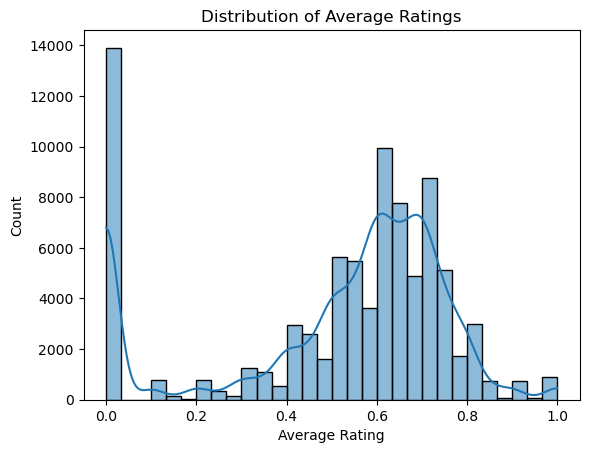

In [24]:
movie_ida = movie_features_scaled.copy()

sns.histplot(movie_ida['avgRating'], bins=30, kde=True)
plt.title("Distribution of Average Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Count")
plt.show()

#### Average Ratings by Movie Type
To explore whether sequels or superhero films were better rated then other films, I considered a box plot to compare. This will aid in seeing if this is a worthwhile hypothesis to further explore.

Based on this preliminary data analysis, there does appear to be some merit to studios investing in superhero films, and franchises, as they have a higher average audience rating and smaller variance, so are consistently well liked, compared to other films. In fact poorly rated superhero films are outliers.

However, sequels rarely seem to perform well, so why do studios keep making them? There is a wide spread of ratings for sequels, with some being well-rated, but on average are not as well received as 'Other' films.

This would need to be further analysed, as the threshold picked may be too low.

In [26]:
# Threshold to determine whether a tag applies
threshold = 0.7

# Create binary flags
movie_ida['is_superhero'] = movie_ida[possible_superhero_tags].max(axis=1) > threshold
movie_ida['is_sequel'] = movie_ida[possible_sequel_tags].max(axis=1) > threshold

# Create a single label column
def classify(row):
    if row['is_superhero'] and row['is_sequel']:
        return 'Superhero Sequel'
    elif row['is_superhero']:
        return 'Superhero Only'
    elif row['is_sequel']:
        return 'Sequel Only'
    else:
        return 'Other'

movie_ida['category'] = movie_ida.apply(classify, axis=1)
print(movie_ida['category'].value_counts())

category
Other               81893
Superhero Only       1599
Sequel Only           694
Superhero Sequel      475
Name: count, dtype: int64


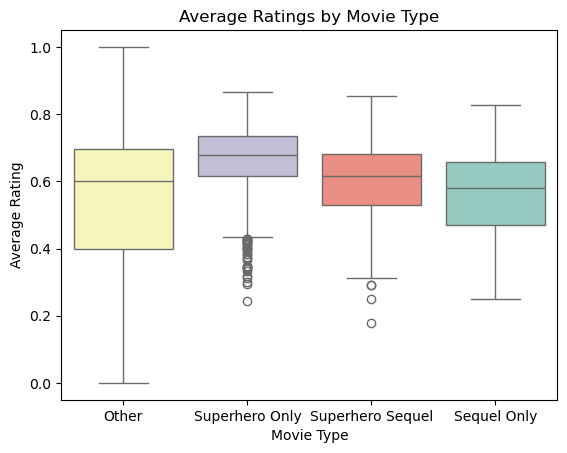

In [27]:
sns.boxplot(x='category', y='avgRating', data=movie_ida, order=['Other', 'Superhero Only', 'Superhero Sequel', 'Sequel Only'], hue='category', palette='Set3', legend=False)
plt.title("Average Ratings by Movie Type")
plt.xlabel("Movie Type")
plt.ylabel("Average Rating")
plt.show()

#### Ratings over Time

Have the quality of films (in the opinions of audiences) decreased over time?
Considering a simple time series graph, potentially. Audience rating of films have increased from 1940 to ~2010, but have sharply fallen since then. This suggests that I am not alone in believing that the quality in films has decreased of late. This is potentially related to the increase in streaming services and people using streaming services, as does fit with the timing. However, I do not have the data required to explore this fully and therefore can only conjecture.

Text(0.5, 1.0, 'Average Rating Over Time')

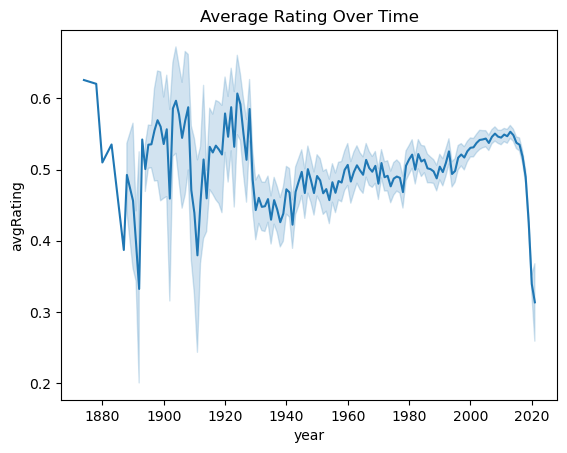

In [29]:
movie_ida['year'] = movie_ida['title'].str.extract(r'\((\d{4})\)').astype(float)

sns.lineplot(data=movie_ida, x='year', y='avgRating')
plt.title("Average Rating Over Time")

#### Correlation betweeen tags and Average Ratings

What makes audiences think a film is good, or bad. Considering simple correlation, and ordering these, they currently prove not very useful. The positive tags are obviously positive in their tone, and the negative the same. Although tags like 'predictable' and 'crappy_sequel' do link in to the ideas I wish to explore. However, from the graphs above, 'crappy_sequel' tag was included in the Box Plot, yet the ratings for films in that category were at least 0.3, so not particularly bad.

In [31]:
# Correlation between tag score and avg rating
tag_columns = [col for col in movie_ida.columns if col not in [
    'title', 'directedBy', 'starring', 'imdbId', 'item_id', 'avgRating', 'category', 'year', 'is_superhero', 'is_sequel'
]]

tag_corr = movie_ida[tag_columns].corrwith(movie_ida['avgRating'])
tag_corr = tag_corr.sort_values(ascending=False)


print(f"Top positive tag correlations:\n{tag_corr.head(10)}\n\nTop negative tag correlations:\n{tag_corr.tail(10)}")

Top positive tag correlations:
movielens_top_pick               0.702422
suprisingly_clever               0.637345
beautifully_filmed               0.625907
good_music                       0.597308
criterion                        0.590033
golden_palm                      0.588218
melancholy                       0.583365
great_cinematography             0.582096
oscar_best_supporting_actress    0.558648
storytelling                     0.556862
dtype: float64

Top negative tag correlations:
predictable             -0.625456
computer_game           -0.640598
bad_acting              -0.646072
horrible                -0.653342
crappy_sequel           -0.664641
based_on_a_video_game   -0.673081
bad_plot                -0.681280
bad                     -0.709019
bad_script              -0.712833
so_bad_it_s_funny       -0.773558
dtype: float64


#### Proportion of Sequels Over Time
Do we have more sequels now then previously.
According to my time series graph, **No**. Most sequels were produced in the 1980's - 2010's.

<Axes: title={'center': 'Proportion of Sequels Over Time'}, xlabel='year', ylabel='% of Movies'>

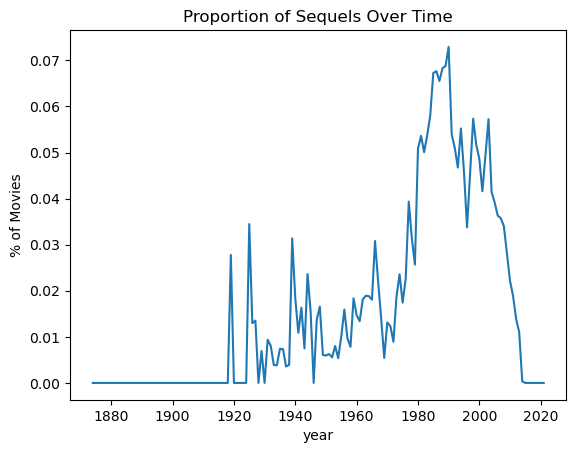

In [33]:
movie_ida['is_sequel'] = movie_ida[possible_sequel_tags].max(axis=1) > 0.5
sequel_by_year = movie_ida.groupby('year')['is_sequel'].mean()

sequel_by_year.plot(title="Proportion of Sequels Over Time", ylabel="% of Movies")

> **Conclusion**
> 
> We have found some interesting relationships with average ratings and these tags across our data set. However, even the scope of our work has changed, our recommender and the process in creating this may shed some light on why sequels are often favoured (if sequels are often recommended) and the prevelance of *themes* of films, like superhero, or action franchises. 

## Dimensionality Reduction
---

### Principal Component Analysis (PCA)
---

To start with, we will just consider the `movie_features` data frame. The key issue with this so far is that is has a very high dimension, which would decrease the efficiency of any approach I could take to cluster these films based on these tags.

The issues with high dimensionality are:
- Clustering becomes unreliable because all distances converge
- Features may be highly correlated, adding redundant information
- Computation becomes slower and harder to visualise

According to Elston (2025), the **"curse of dimensionality"** causes clusters to become indistinguishable and overfitting more likely.

We aim to reduce dimensionality while preserving variance and local structure.

As there are $1,084$ tags, it is safe to assume some of these will be quite similar, for example, we can see there is `007` and `007_series`, which should be linked, and `world_politics` and `world_war_i`, which are also going to be related. As such, there is likely a  correlation between some tags, and this can be used to reduce the dimensionality. The Principal Component Analysis (PCA) algorithm will consider the correlation between each tag for these films to help group them together. Later, we hope to be able to condense these into a more specific genre. We will consider the most and least weighted tags for each Principal Component (PC) group in order to classify them.

In using this algorithm, I am assuming a linear relationship between each tag. Each PC will hopefully be a linear combination of tags which can suggest a type or genre of film to aid us in further analysis.

This should reduce the noise from the data set, whilst still being able to explain the variance in the data.

In [21]:
def plot_normal(X, pca_model):
    X = pd.DataFrame(X, columns=['axis1','axis2'])
    _ = sns.jointplot(
        x='axis1', y='axis2', data=X, 
        xlim=(-4.5, 4.5), ylim=(-4.5, 4.5)
    )
    plt.xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]*100:.1f}%)')

def plot_variance_ratio(pca_model):   
    n = len(pca_model.explained_variance_ratio_)
    plt.scatter(range(1, n + 1), pca_model.explained_variance_ratio_)    
    plt.hlines(0, 1, n, color='red')
    plt.xlabel('Component number')
    plt.ylabel('Explained variance ratio')
    plt.title('Explained variance ratio vs. component number')
    plt.grid(True)
    plt.show()

In [22]:
# Get rows that are fully non-NaN in tag columns
tag_columns = [col for col in movie_features_scaled.columns if col not in ['title', 'directedBy', 'starring', 'avgRating', 'imdbId', 'item_id']]
valid_tag_rows = movie_features_scaled[tag_columns].dropna()

In [23]:
pca = PCA()
%time pca.fit(valid_tag_rows)

%time tag_pca = pca.transform(valid_tag_rows)

CPU times: total: 3.98 s
Wall time: 750 ms
CPU times: total: 812 ms
Wall time: 136 ms


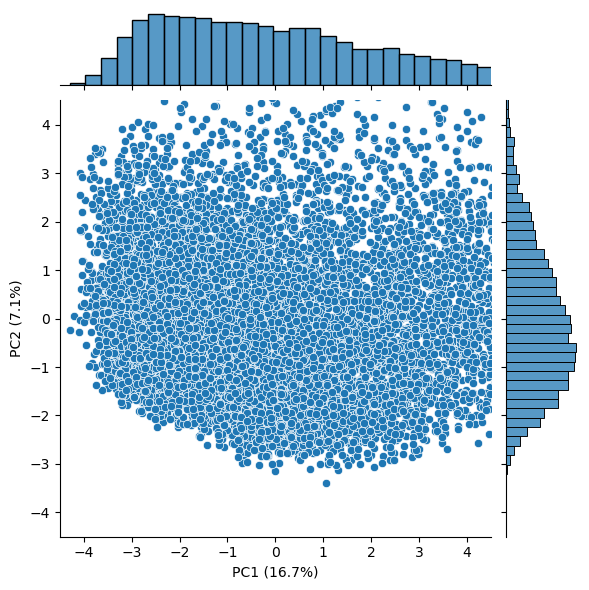

In [24]:
plot_normal(tag_pca[:, :2], pca)

This is a very dense and spread out graph of our data, showing that even though these PC's explain the most variance, they have not done so well. PC2 does show a slightly skewed distribution, but PC1 is almost uniform distribution, which may suggest that we will have future issues with clustering.

Eigenvalues (explained variances):
[5.4337 2.3156 1.8667 ... 0.     0.     0.    ]


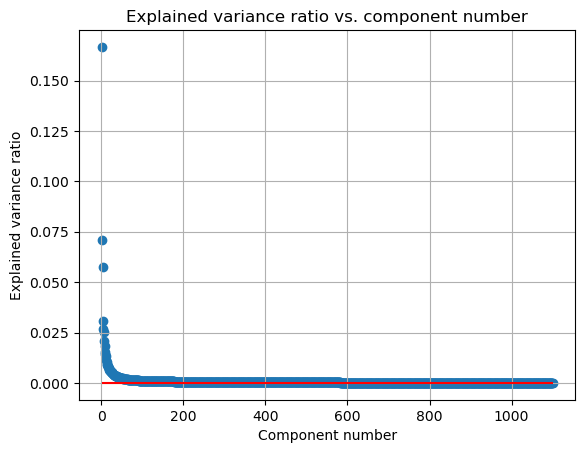

In [25]:
print("Eigenvalues (explained variances):")
print(np.round(pca.explained_variance_, 4))

plot_variance_ratio(pca)

These graphs show that the first two Principal Componenets account for $16.7+7.1 = 23.8\%$ which is quite high considering the number of initial variable. This is confirmed with the explained variance, which shows the sharp drop off in the amount of variance each PC contributes to. Meaning that we can significantly reduce dimensionality. 

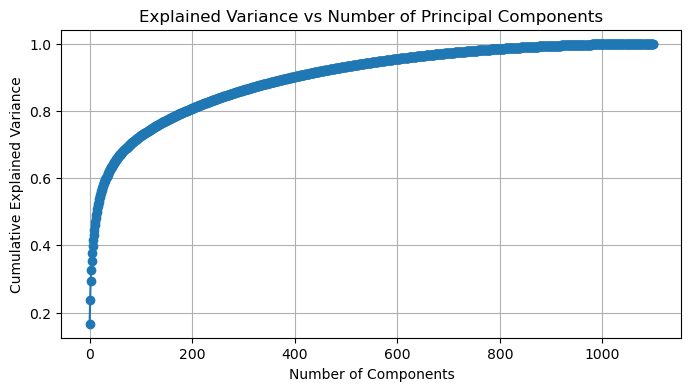

In [26]:
# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Principal Components')
plt.grid(True)
plt.show()

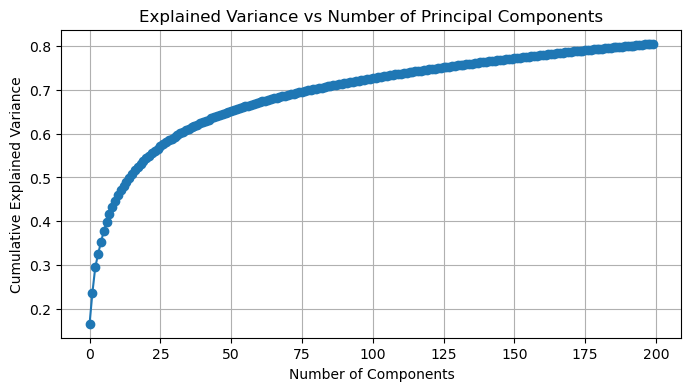

In [27]:
pca = PCA(n_components=200)
tag_pca = pca.fit_transform(valid_tag_rows)

# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Principal Components')
plt.grid(True)
plt.show()

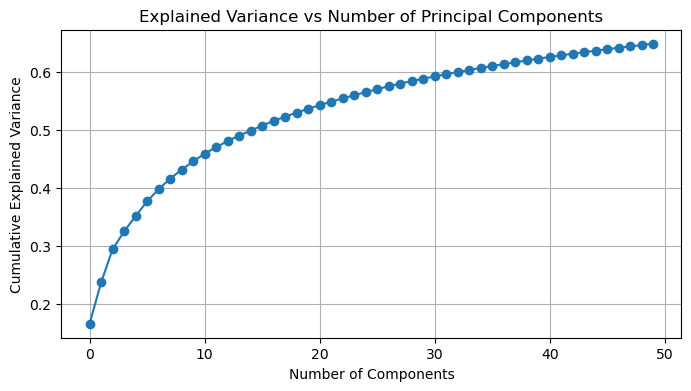

In [28]:
pca = PCA(n_components=50)
tag_pca = pca.fit_transform(valid_tag_rows)

# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Principal Components')
plt.grid(True)
plt.show()

From this, approximately $60\%$ of our variance is described by only around 30 companents, and the 'elbow' here seems to be in the 20-30 range, therefore we will consider a reduction to 30 compenents to retain sufficient information for my exploration. 

This may be an issue later on when it comes to clustering, but we will check to see whether it has made a significant impact or not. For now, reducing to 30 companents seems like the best way forward.

In [29]:
pca = PCA(n_components=30)
tag_pca = pca.fit_transform(valid_tag_rows)

transformation_matrix = pd.DataFrame(
    pca.components_,
    columns=valid_tag_rows.columns
)
transformation_matrix.index = [f'PC{i+1}' for i in range(transformation_matrix.shape[0])]

print(transformation_matrix.iloc[:, :6].round(3))

        007  007_series  18th_century  1920s  1930s  1950s
PC1  -0.001      -0.001         0.018  0.032  0.019  0.010
PC2   0.003       0.003        -0.010 -0.008 -0.004 -0.001
PC3   0.000      -0.000        -0.023 -0.010 -0.020 -0.006
PC4  -0.004      -0.004        -0.027 -0.019 -0.017 -0.004
PC5  -0.001      -0.001         0.034  0.032  0.021  0.011
PC6  -0.007      -0.007        -0.023 -0.050 -0.044 -0.014
PC7  -0.005      -0.004        -0.002  0.011  0.017  0.008
PC8  -0.003      -0.003         0.015  0.020  0.008  0.006
PC9   0.004       0.004         0.022  0.048  0.020  0.017
PC10 -0.002      -0.001         0.020 -0.029 -0.023 -0.020
PC11 -0.001      -0.001         0.004  0.018  0.021  0.017
PC12 -0.001      -0.000         0.044  0.010  0.011  0.003
PC13  0.009       0.008         0.097  0.017  0.037 -0.004
PC14 -0.007      -0.007        -0.028  0.015  0.009 -0.002
PC15 -0.007      -0.006         0.004  0.027  0.022  0.013
PC16  0.018       0.017        -0.010 -0.060 -0.039  0.0

Eigenvalues (explained variances):
[5.4337 2.3156 1.8667 0.9977 0.8661 0.8241 0.6818 0.5952 0.5006 0.4662
 0.4365 0.3664 0.3425 0.301  0.2867 0.2785 0.2646 0.2396 0.2281 0.2144
 0.2015 0.1968 0.1825 0.1809 0.1722 0.1672 0.1626 0.1508 0.1384 0.1327]


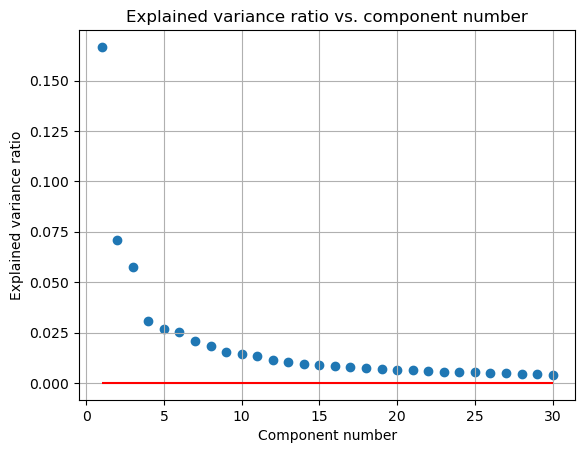

In [30]:
print("Eigenvalues (explained variances):")
print(np.round(pca.explained_variance_, 4))

plot_variance_ratio(pca)

So from this, really after 20 PC's, the variance explained is minimal and it is a clear elbow point of our *Explained Variance* graph, but I do want to ensure we have enough different PCs to be able to define a sufficent type and genre of film. Therefore, we will use 30 PC's. 

In [31]:
# Store as DataFrame for merging
pca_df = pd.DataFrame(tag_pca, columns=[f'PC{i+1}' for i in range(30)], index=valid_tag_rows.index)
movie_features_pca = pd.concat([movie_features_scaled, pca_df], axis=1)

movie_features_pca.drop(columns=tag_columns, inplace = True)

movie_features_pca.head()

title       directedBy  \
0                    Toy Story (1995)    John Lasseter   
1                      Jumanji (1995)     Joe Johnston   
2             Grumpier Old Men (1995)    Howard Deutch   
3            Waiting to Exhale (1995)  Forest Whitaker   
4  Father of the Bride Part II (1995)    Charles Shyer   

                                            starring  avgRating  imdbId  \
0  Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...   0.778292  114709   
1  Jonathan Hyde, Bradley Pierce, Robin Williams,...   0.653210  113497   
2  Jack Lemmon, Walter Matthau, Ann-Margret , Sop...   0.634292  113228   
3  Angela Bassett, Loretta Devine, Whitney Housto...   0.573648  114885   
4  Steve Martin, Martin Short, Diane Keaton, Kimb...   0.615240  113041   

   item_id       PC1       PC2       PC3       PC4  ...      PC21      PC22  \
0        1  0.555630  2.780478 -4.072990  0.834200  ... -0.354916  0.027122   
1        2 -2.183376  1.431176 -1.661436 -0.529751  ...  0.133898  0.339613   
2        3 -2.441146 -0.317177 -0.769501  0.500814  ... -0.336009  0.458725   
3        4 -2.010603 -1.445083 -0.995050 -0.329119  ...  0.082239  0.115969   
4        5 -2.571122 -0.745268 -1.512939  0.476479  ... -0.140057  0.242376   

       PC23      PC24      PC25      PC26      PC27      PC28      PC29  \
0 -0.354286  0.132299  0.028472 -0.001269 -0.525475  0.029984 -0.315745   
1 -0.482052 -0.245257  0.707468 -0.738136 -0.577004  0.058667  0.191341   
2  0.135672 -0.403648 -0.396362  0.140235 -0.012220 -0.474976 -0.350394   
3  0.126448  0.049739 -0.190517 -0.331277  0.265244 -0.613804  0.155217   
4  0.223947 -0.011456 -0.119740 -0.216915  0.013121 -0.354364 -0.243930   

       PC30  
0 -0.366649  
1  0.169077  
2 -0.131962  
3 -0.067659  
4 -0.166808  

[5 rows x 36 columns]

Above gives us the PC value, which by its self does not mean much within our context, so we will use these to help decide which group each  film belongs to to help us determine its genre. So, we will consider the linear combination of original tags that form each PC, and use this to determine its genre.

In [32]:
tag_columns = valid_tag_rows.columns.tolist()  

# Get the component loadings matrix (30 PCs × 1084 tags)
loadings = pd.DataFrame(
    pca.components_,  # shape = (n_components, n_features)
    columns=tag_columns,  # the original tag names
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)

In [33]:
pc_cols = [col for col in movie_features_pca.columns if col not in ['title', 'directedBy', 'starring', 'avgRating', 'imdbId', 'item_id']]

# Print only the first 3, all were previously printed for analysis
for col in ['PC1', 'PC2', 'PC3']:
    print(f"{col}\nPositively weighted columns:\n{loadings.loc[col].sort_values(ascending=False).head(10)}\nNegatively weighted columns:\n{loadings.loc[col].sort_values(ascending=True).head(10)}\n")   

PC1
Positively weighted columns:
golden_palm          0.113280
cinematography       0.101127
independent_film     0.101049
character_study      0.100740
melancholy           0.095320
existentialism       0.094730
social_commentary    0.093396
loneliness           0.092662
depression           0.092109
tragedy              0.089458
Name: PC1, dtype: float64
Negatively weighted columns:
so_bad_it_s_funny          -0.079504
big_budget                 -0.073990
bad_plot                   -0.072159
predictable                -0.065983
based_on_a_video_game      -0.061625
not_as_good_as_the_first   -0.058352
computer_game              -0.055461
bad_acting                 -0.054324
teen                       -0.051638
special_effects            -0.051480
Name: PC1, dtype: float64

PC2
Positively weighted columns:
action              0.122441
suspense            0.114991
cool                0.111689
revenge             0.110908
gunfight            0.109301
foul_language       0.108963
chase   

I wished to understand what each PC column refered to within the context of films. I used ChatGPT to analyse the above (originally this was printed for all PC's, but have reduced to 3 as an example) and summarise what type of film each PCA column linked to (Positevly Weighted tags) and what they are definitely not related to (Negatively weighted tags). Both of these may be useful to fully help us classify each group.

| PC   | Theme (Positively Weighted Tags)                                                                                             | Negatively Weighted Tags (Least Aligned)                                               |
|------|-------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------|
| PC1  | Critically acclaimed, artistic, melancholic, indie films with deep social commentary.                                        | Badly acted, predictable, formulaic, big-budget, video game adaptations.                |
| PC2  | Action-packed revenge thrillers with suspense, gunfights, and chase scenes.                                                  | Intimate, character-driven, indie or relationship-focused films.                        |
| PC3  | Dark horror and disturbing psychological thrillers with violence and blood.                                                  | Heartwarming, sentimental, romantic and family-friendly films.                          |
| PC4  | Comedic, witty, quirky, and humorous films with satirical tone.                                                              | War dramas and tense, serious historical or survival films.                             |
| PC5  | Wholesome family-friendly films and animated classics with fun and nostalgia.                                                | Gritty crime thrillers, intense dramas with foul language and FBI themes.               |
| PC6  | Emotional, psychological, and touching life stories, often with teen or relationship focus.                                 | Violent crime thrillers with gunfights and chase scenes.                                |
| PC7  | Horror classics and slasher-style films featuring gore, suspense and supernatural elements.                                  | Futuristic, tech-heavy, visually stylish or philosophical films.                        |
| PC8  | Teen-centered dramas, hip-hop culture, political or civil conflict-related themes.                                           | Clever, stylish, twist-based mystery and dialogue-driven films.                         |
| PC9  | Romantic comedies and emotional, gendered or nostalgic dramas.                                                               | Sci-fi, intellectual or political thrillers, cult or high-concept themes.               |
| PC10 | Animated children’s and fantasy films with cartoon elements and talking animals.                                             | Award-winning dramas, serious or romantic comedies, silly or ridiculous humour.         |
| PC11 | Science fiction with philosophical and identity themes, often set in dystopian or surveillance-based settings.               | Violent, action-packed or epic thrillers.                                               |
| PC12 | Romantic and erotic dramas with themes of relationships, sexuality, and sensuality.                                          | Child-centered or animated films; emotional family content.                             |
| PC13 | British period dramas and literary adaptations, historical or political in tone.                                             | Gritty, gang-related action or hitman thrillers.                                        |
| PC14 | Cartoony or controversial content mixing kids and adult themes, often edgy or satirical.                                     | British or indie dramas with feel-good or bittersweet tones.                            |
| PC15 | Superhero and comic-book franchise films, often sequels with vigilantism.                                                    | Surreal, romantic, or comedic films with female leads or experimental elements.         |
| PC16 | Teen, high school, coming-of-age films with conspiracies or secrets.                                                         | Violent psychological thrillers or video game-based stories.                            |
| PC17 | Teen comedies and high school dramas with pop culture influence.                                                             | Slow-paced emotional dramas, family-focused or philosophical content.                   |
| PC18 | Romantic post-apocalyptic thrillers, dark comedies, and literary crime adaptations.                                          | Teen dramas and fast-paced youth films, art-house or school-based content.              |
| PC19 | Teen-centered stories with hip-hop or gang-related themes.                                                                   | Action and superhero violence, overtly sexual or disturbing content.                    |
| PC20 | Surreal and fantastical stories set in mythological or dark fantasy worlds.                                                  | British or foreign realist dramas, family films or love stories.                        |
| PC21 | Book adaptations, British crime thrillers and hitman-focused stories.                                                        | Documentaries, suspenseful murder mysteries, or political dramas.                       |
| PC22 | WWII and war-themed dramas with Irish or historical settings.                                                                | Politically themed or colourful musicals; social justice and culture clash films.       |
| PC23 | Dark comedies, independent dramas with fast pace and literary elements.                                                      | Sexualised or childhood-themed films, crime and parody-focused stories.                 |
| PC24 | Campy, surreal, quirky or violent action thrillers.                                                                          | Uplifting comedies, post-apocalyptic dramas, slapstick or overly visual films.          |
| PC25 | Jewish WWII films, Holocaust-related historical war dramas.                                                                  | Alien-based sci-fi comedies, visually spectacular or hip-hop-themed films.              |
| PC26 | Biographical and historical period dramas based on true stories.                                                             | Fantastical, capitalist critique, or fairy tale content.                                |
| PC27 | Nocturnal, stylised anti-war films with vigilante or dystopian themes.                                                       | Nudity-heavy dramas, poverty, or religious controversy.                                 |
| PC28 | Indie or Australian surreal dramas with gaming and hip-hop influence.                                                        | Romantic family stories or murder mysteries with sentimental undertones.                |
| PC29 | Cult classics, book adaptations, and campy or cheesy films.                                                                  | Music or supernatural-themed films, sequels or politically heavy stories.               |
| PC30 | Religious or philosophical films with deep dialogue and artistic themes.                                                     | LGBTQ+ themed comedies, dark comedies, and war-focused dramas.                          |


*AI-generated analysis: The interpretation and summary of PCA component loadings into labelled categories (e.g. “Critically acclaimed indie films”, “Teen horror”, etc.) and their corresponding markdown table and csv file were generated using ChatGPT.*

*Prompt used:*
*"I want to figure out what each PC is. Can you summarise what type of film each PC column represents? Put this in a LaTeX table for me to copy into a markdown cell." + Output from previous cell.*

*Tool: ChatGPT (OpenAI), July 2025*
*Note: All AI-generated content has been reviewed and interpreted by me to ensure alignment with the goals of the project and accurate domain representation.*

Now, we have managed to reduce the dimension form 1084, to 30, and have a clear idea of the types of films associated with each of these groups. This should make the next step of clustering and similarity searches easier, and easier to interpret within the context of the problem.

What is interesting is that PC1 covers $16.7\%$ of the variation. Based on the analysis of the prevalent tag, these are more aligned with critically acclaimed films. The next, PC2 explaining $7.1\%$ of the variation describes action-packed films, showing how many films can be put into either of these categories. 

Overall, these themes do a good job are describing common films beyond genre, and should be able to give us more specific and meaningful recommendations using these user-derived tags. 

From this, it may be useful to classify which of these themes each film falls under. A simple (albeit not the most exact) is to allocate each film based on the maximum value.

In [34]:
pc_descriptions = pd.read_csv("Data/PCA_Component_Descriptions.csv")

pc_descriptions_map = dict(zip(pc_descriptions['principal_component'], pc_descriptions['description']))

theme = movie_features_pca[[f'PC{i+1}' for i in range(30)]].dropna().idxmax(axis=1).map(pc_descriptions_map)

movie_features_pca.insert(6, 'theme', theme)

movie_features_pca.head(10)

title       directedBy  \
0                    Toy Story (1995)    John Lasseter   
1                      Jumanji (1995)     Joe Johnston   
2             Grumpier Old Men (1995)    Howard Deutch   
3            Waiting to Exhale (1995)  Forest Whitaker   
4  Father of the Bride Part II (1995)    Charles Shyer   
5                         Heat (1995)     Michael Mann   
6                      Sabrina (1995)   Sydney Pollack   
7                 Tom and Huck (1995)     Peter Hewitt   
8                 Sudden Death (1995)      Peter Hyams   
9                    GoldenEye (1995)  Martin Campbell   

                                            starring  avgRating  imdbId  \
0  Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...   0.778292  114709   
1  Jonathan Hyde, Bradley Pierce, Robin Williams,...   0.653210  113497   
2  Jack Lemmon, Walter Matthau, Ann-Margret , Sop...   0.634292  113228   
3  Angela Bassett, Loretta Devine, Whitney Housto...   0.573648  114885   
4  Steve Martin, Martin Short, Diane Keaton, Kimb...   0.615240  113041   
5  Robert De Niro, Al Pacino, Val Kilmer, Jon Voi...   0.771098  113277   
6  Harrison Ford, Greg Kinnear, Nancy Marchand, J...   0.674488  114319   
7  Jonathan Taylor Thomas, Brad Renfro, Eric Schw...   0.623356  112302   
8  Raymond J. Barry, Powers Boothe, Jean-Claude V...   0.600484  114576   
9  Pierce Brosnan, Sean Bean, Famke Janssen, Izab...   0.686680  113189   

   item_id                                             theme       PC1  \
0        1                   High-octane action and suspense  0.555630   
1        2           Family-friendly classics and animations -2.183376   
2        3                     Fantasy and surreal mythology -2.441146   
3        4              Post-apocalyptic dark romantic crime -2.010603   
4        5                     Fantasy and surreal mythology -2.571122   
5        6  Critically acclaimed, artistic, emotional dramas  3.370178   
6        7                        Erotic and romantic themes -1.931331   
7        8           Children’s animation and fantasy worlds -2.574883   
8        9               Dark, violent, disturbing thrillers -2.981857   
9       10                   High-octane action and suspense -1.558499   

        PC2       PC3  ...      PC21      PC22      PC23      PC24      PC25  \
0  2.780478 -4.072990  ... -0.354916  0.027122 -0.354286  0.132299  0.028472   
1  1.431176 -1.661436  ...  0.133898  0.339613 -0.482052 -0.245257  0.707468   
2 -0.317177 -0.769501  ... -0.336009  0.458725  0.135672 -0.403648 -0.396362   
3 -1.445083 -0.995050  ...  0.082239  0.115969  0.126448  0.049739 -0.190517   
4 -0.745268 -1.512939  ... -0.140057  0.242376  0.223947 -0.011456 -0.119740   
5  2.587224 -0.286533  ... -0.021805 -0.069529  0.203789 -0.512986 -0.005694   
6 -1.100723 -1.406837  ... -0.125313  0.101128  0.149521  0.376709 -0.344687   
7 -1.180084 -0.805802  ...  0.194734 -0.090331  0.388763 -0.341887  0.259922   
8 -0.100481  0.663575  ...  0.402879 -0.162986  0.332795 -0.120138  0.216308   
9  2.428740 -0.144614  ...  0.962009 -0.191521  0.952307  0.255111  0.015196   

       PC26      PC27      PC28      PC29      PC30  
0 -0.001269 -0.525475  0.029984 -0.315745 -0.366649  
1 -0.738136 -0.577004  0.058667  0.191341  0.169077  
2  0.140235 -0.012220 -0.474976 -0.350394 -0.131962  
3 -0.331277  0.265244 -0.613804  0.155217 -0.067659  
4 -0.216915  0.013121 -0.354364 -0.243930 -0.166808  
5 -0.226087  0.584169  0.410350  0.025494  0.061267  
6 -0.140564 -0.060955 -0.354218  0.109539  0.085964  
7  0.244379  0.152238 -0.175016  0.832677  0.117922  
8  0.121196 -0.475759  0.340064  0.394403 -0.419127  
9 -0.194668 -0.440277 -0.173690 -0.801762  0.098521  

[10 rows x 37 columns]

This is clearly too simple of an approach, as *Toy Story* a family-friendly animated film, has the theme *High-octane action and suspense*, which is not completely wrong, but maybe misleading and may affect future analysis. Therefore, let us consider allocating based on a threshold of minimum PC value, and concatenating all relvant themes. However, as this may lead to some films not being classified, I have kept the maximum value as well. The threshold of $2$ was picked as based on a few of the films seen, and considering their PC values, this did seem to match with describing the film well, below $2$ and we could have multiple descriptions for each film and some may not be very accruate, or only align with a few aspects of the description.

In [35]:
# Set the threshold for strong PCA component values
threshold = 2
pcs = [f'PC{i+1}' for i in range(30)]

# Function to extract themes above threshold, or fallback to max
def get_theme(row):
    above_threshold = row[row > threshold].index.tolist()
    if above_threshold:
        return ', '.join(pc_descriptions_map[pc] for pc in above_threshold)
    else:
        max_pc = row.idxmax()
        return pc_descriptions_map[max_pc]

# Apply the function row-wise
movie_features_pca['theme'] = movie_features_pca[pcs].dropna().apply(get_theme, axis=1)

movie_features_pca.head(10)

title       directedBy  \
0                    Toy Story (1995)    John Lasseter   
1                      Jumanji (1995)     Joe Johnston   
2             Grumpier Old Men (1995)    Howard Deutch   
3            Waiting to Exhale (1995)  Forest Whitaker   
4  Father of the Bride Part II (1995)    Charles Shyer   
5                         Heat (1995)     Michael Mann   
6                      Sabrina (1995)   Sydney Pollack   
7                 Tom and Huck (1995)     Peter Hewitt   
8                 Sudden Death (1995)      Peter Hyams   
9                    GoldenEye (1995)  Martin Campbell   

                                            starring  avgRating  imdbId  \
0  Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...   0.778292  114709   
1  Jonathan Hyde, Bradley Pierce, Robin Williams,...   0.653210  113497   
2  Jack Lemmon, Walter Matthau, Ann-Margret , Sop...   0.634292  113228   
3  Angela Bassett, Loretta Devine, Whitney Housto...   0.573648  114885   
4  Steve Martin, Martin Short, Diane Keaton, Kimb...   0.615240  113041   
5  Robert De Niro, Al Pacino, Val Kilmer, Jon Voi...   0.771098  113277   
6  Harrison Ford, Greg Kinnear, Nancy Marchand, J...   0.674488  114319   
7  Jonathan Taylor Thomas, Brad Renfro, Eric Schw...   0.623356  112302   
8  Raymond J. Barry, Powers Boothe, Jean-Claude V...   0.600484  114576   
9  Pierce Brosnan, Sean Bean, Famke Janssen, Izab...   0.686680  113189   

   item_id                                              theme       PC1  \
0        1  High-octane action and suspense, Family-friend...  0.555630   
1        2            Family-friendly classics and animations -2.183376   
2        3                      Fantasy and surreal mythology -2.441146   
3        4               Post-apocalyptic dark romantic crime -2.010603   
4        5                      Fantasy and surreal mythology -2.571122   
5        6  Critically acclaimed, artistic, emotional dram...  3.370178   
6        7                         Erotic and romantic themes -1.931331   
7        8            Children’s animation and fantasy worlds -2.574883   
8        9                Dark, violent, disturbing thrillers -2.981857   
9       10                    High-octane action and suspense -1.558499   

        PC2       PC3  ...      PC21      PC22      PC23      PC24      PC25  \
0  2.780478 -4.072990  ... -0.354916  0.027122 -0.354286  0.132299  0.028472   
1  1.431176 -1.661436  ...  0.133898  0.339613 -0.482052 -0.245257  0.707468   
2 -0.317177 -0.769501  ... -0.336009  0.458725  0.135672 -0.403648 -0.396362   
3 -1.445083 -0.995050  ...  0.082239  0.115969  0.126448  0.049739 -0.190517   
4 -0.745268 -1.512939  ... -0.140057  0.242376  0.223947 -0.011456 -0.119740   
5  2.587224 -0.286533  ... -0.021805 -0.069529  0.203789 -0.512986 -0.005694   
6 -1.100723 -1.406837  ... -0.125313  0.101128  0.149521  0.376709 -0.344687   
7 -1.180084 -0.805802  ...  0.194734 -0.090331  0.388763 -0.341887  0.259922   
8 -0.100481  0.663575  ...  0.402879 -0.162986  0.332795 -0.120138  0.216308   
9  2.428740 -0.144614  ...  0.962009 -0.191521  0.952307  0.255111  0.015196   

       PC26      PC27      PC28      PC29      PC30  
0 -0.001269 -0.525475  0.029984 -0.315745 -0.366649  
1 -0.738136 -0.577004  0.058667  0.191341  0.169077  
2  0.140235 -0.012220 -0.474976 -0.350394 -0.131962  
3 -0.331277  0.265244 -0.613804  0.155217 -0.067659  
4 -0.216915  0.013121 -0.354364 -0.243930 -0.166808  
5 -0.226087  0.584169  0.410350  0.025494  0.061267  
6 -0.140564 -0.060955 -0.354218  0.109539  0.085964  
7  0.244379  0.152238 -0.175016  0.832677  0.117922  
8  0.121196 -0.475759  0.340064  0.394403 -0.419127  
9 -0.194668 -0.440277 -0.173690 -0.801762  0.098521  

[10 rows x 37 columns]

> #### Conclusion
> 
> We have now established a framework to define the thematic profile of a film using user-ranked tags, potentially offering a more nuanced understanding than traditional genre labels. Our PCA decomposition will be used to support similarity-based recommendations and to build more intuitive, user-focused classifications of films.
>
> A surprising finding from the PCA was the relative position of superhero-related themes. While superhero films are often assumed to dominate the current cinematic landscape, they only emerged prominently in PC15. This suggests that, despite their cultural visibility, these films do not explain a significant portion of the variation in tag-based user perception.
>
> This reinforces the value of using PCA: it highlights the underlying dimensions that structure audience interpretation, beyond simple box office narratives or surface-level genre labels.
Let me know if you want to add visuals to support this (e.g., a loading plot for PC1–PC3) or want to write similar conclusions for UMAP or clustering.

### UMAP
---

As the PCA dimension reduction only explained $60\%$ of the variation, we wanted to explore other possible options. As we assumed that the relationship between tags was linear, this may have been the issue.

Therefore, we considered UMAP (Uniform Manifold Approximation and Projection) as this considers non-linear structures, and preserves both the global and local structures. However, it is harder to interpret within my context.

C:\Users\Liam\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


CPU times: total: 21.5 s
Wall time: 21.7 s


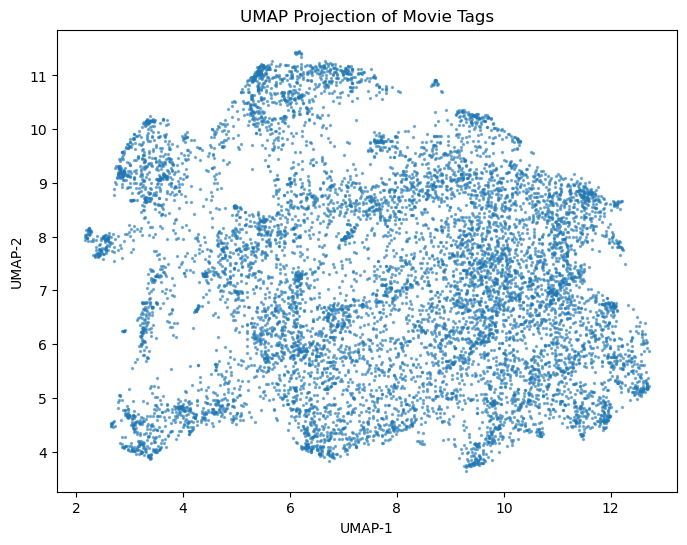

In [36]:
# Subset of your data with valid tags
valid_tag_rows = movie_features_scaled[tag_columns].dropna()

# Instantiate UMAP
reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42)

# Fit and transform
%time umap_embedding = reducer.fit_transform(valid_tag_rows)

# Plot 2D embedding
plt.figure(figsize=(8, 6))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=2, alpha=0.5)
plt.title("UMAP Projection of Movie Tags")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

> #### Conclusion
> ---
> My projection is quite dense and uniformly spread. Therefore, this is not particularly helpful. But it may help explain some future issues we may have with clustering.

## Clustering films based on Tag Data
---

In order to get a better sense of the data, and to help with future recommender models, we will cluster our data based on the PCA groupings. To see whether or not our PCA to reduce dimensionality didn't remove too much of the data, we will also compare with the inital tags.

### K-Means
---

Considering the OPTICS algorithm for clustering, this has not worked. After tweaking the metrics used and the distance calculation, we mostly end up with 1 cluster involving all the data, or some small clusters and most data not being assigned to a cluster.

Due to this, just to see whether clusters do exist, I will consider k-Means with a range of different `n_clusters` to see if this produces anything of value.

In [37]:
pcs = [f'PC{i+1}' for i in range(30)]
clustering_data = movie_features_pca[pcs + ['avgRating']].dropna()
clustering_data.shape

(9730, 31)


--- KMeans with 5 clusters ---
                count      mean
kmeans_cluster                 
0                1439  0.592379
1                2828  0.696736
2                 872  0.584005
3                2887  0.604855
4                1704  0.746903
Calinski-Harabasz Score (k=7): 1236.12


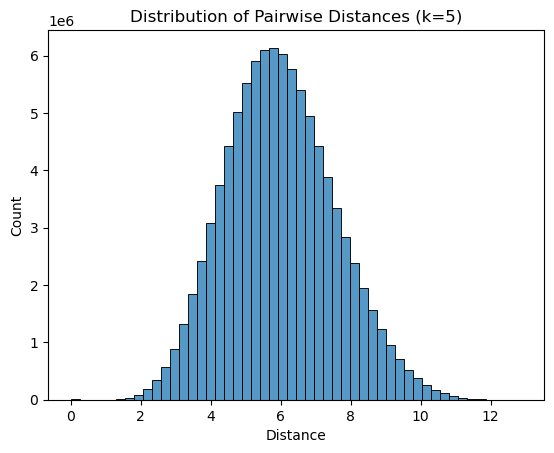


--- KMeans with 6 clusters ---
                count      mean
kmeans_cluster                 
0                1708  0.579658
1                1260  0.710694
2                1110  0.746515
3                2122  0.573000
4                1340  0.725535
5                2190  0.661511
Calinski-Harabasz Score (k=7): 1098.50


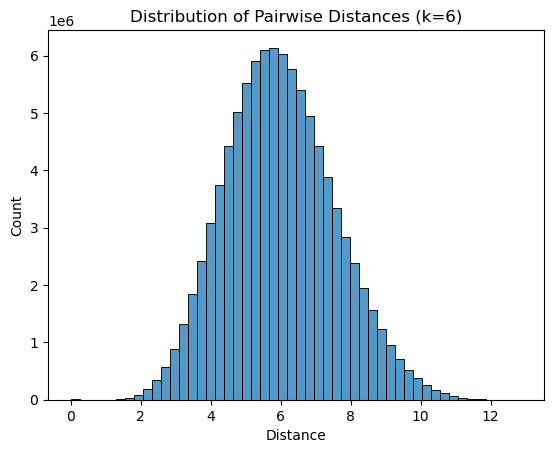


--- KMeans with 7 clusters ---
                count      mean
kmeans_cluster                 
0                1209  0.589053
1                1181  0.713403
2                 803  0.579100
3                2078  0.576006
4                1066  0.746503
5                1271  0.728411
6                2122  0.665767
Calinski-Harabasz Score (k=7): 1029.26


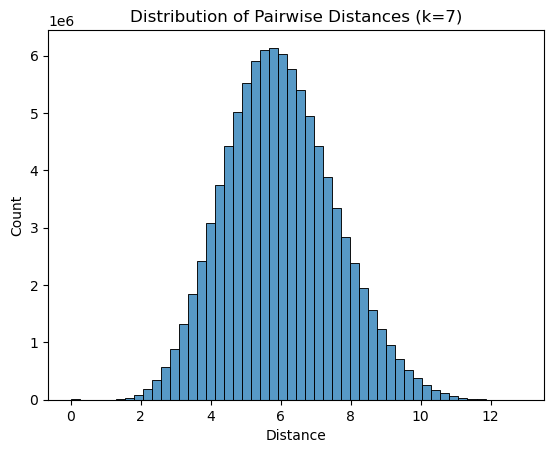

In [39]:
for n_clusters in range(5, 8):
    print(f"\n--- KMeans with {n_clusters} clusters ---")

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    # Fit clustering only on PC features
    clustering_features = clustering_data[pcs]
    labels = kmeans.fit_predict(clustering_features)

    # Create new DataFrame to hold labels and ratings (no leakage)
    kmeans_clustering_data = clustering_data.copy()
    kmeans_clustering_data['kmeans_cluster'] = labels

    # Compute average rating per cluster
    kmeans_cluster_summary = kmeans_clustering_data.groupby('kmeans_cluster')['avgRating'].agg(['count', 'mean'])
    print(kmeans_cluster_summary)

    # Calinski-Harabasz score (higher is better)
    ch_score = calinski_harabasz_score(kmeans_clustering_data[pcs], kmeans_clustering_data['kmeans_cluster'])
    print(f"Calinski-Harabasz Score (k=7): {ch_score:.2f}")
    
    # Plot pairwise distances (between points, not centroids)
    distances = pairwise_distances(clustering_features)
    sns.histplot(distances.flatten(), bins=50)
    plt.title(f"Distribution of Pairwise Distances (k={n_clusters})")
    plt.xlabel("Distance")
    plt.ylabel("Count")
    plt.show()

This does highlight that k-Means has not been useful, as the use of the Euclidean distance on such high-dimensional and categorical data means that my clusters do not show any meaningful separation between clusters. We can see this as we would expect to see a multimodal histogram of our pairwise distances, not a normally disitrbued one. The **Calinski-Harabasz Score** is the same across all values of $k$, suggesting that none of these are useful for clustering our data.

However, just to further visualise this, let us consider `n_clusters` of $k=7$, as each cluster is a good size, many quite similar in of around 1500 films and a range of `avgRating` between $0.54$ and $0.75$ showing that there is some connection between this groups and average rating, but this isn't overwhelming. However, we will colour-code our previous UMAP to check.

CPU times: total: 109 ms
Wall time: 22.7 ms


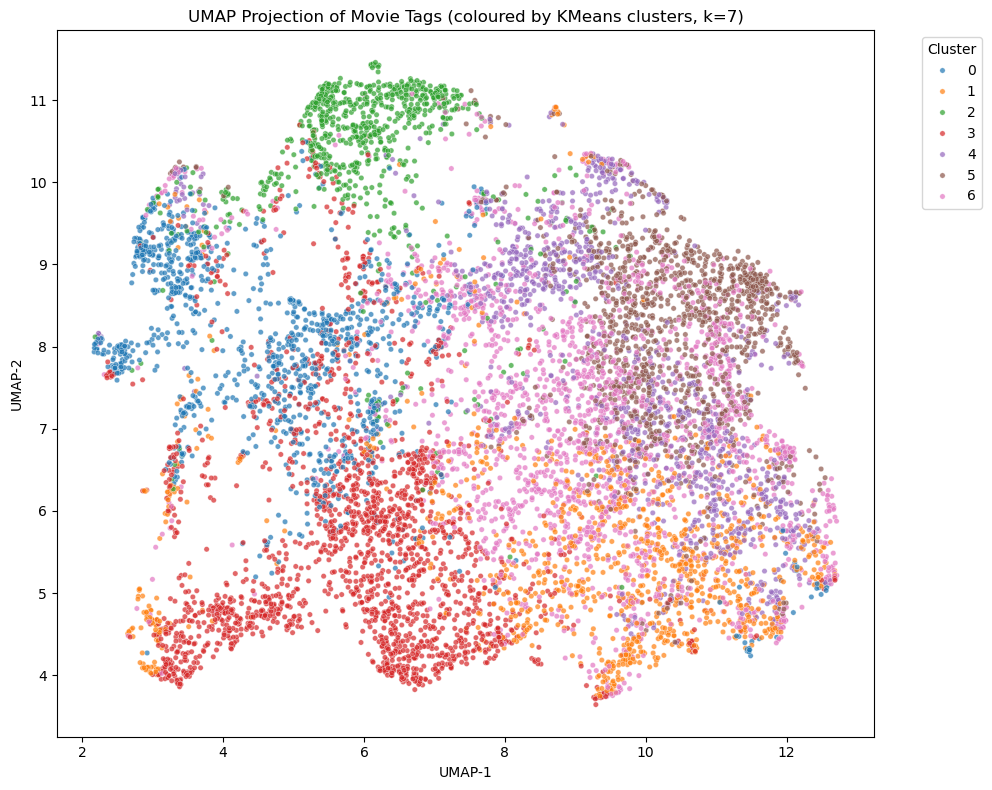

In [68]:
# Final k-Means clustering (k=7)
kmeans = KMeans(n_clusters=7, random_state=42)
clustering_kmeans = clustering_data.copy()

# Fit and assign cluster labels
%time clustering_kmeans['kmeans_cluster'] = kmeans.fit_predict(clustering_kmeans[pcs])

# Combine with UMAP projection
umap_df = pd.DataFrame(umap_embedding, columns=['UMAP-1', 'UMAP-2'], index=clustering_kmeans.index)
umap_df['cluster'] = clustering_kmeans['kmeans_cluster']

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=umap_df,
    x='UMAP-1', y='UMAP-2',
    hue='cluster',
    palette='tab10',
    s=15,
    alpha=0.7
)
plt.title('UMAP Projection of Movie Tags (coloured by KMeans clusters, k=7)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [69]:
# Silhouette score (higher is better, range -1 to 1)
sil_score = silhouette_score(clustering_kmeans[pcs], clustering_kmeans['kmeans_cluster'])
print(f"Silhouette Score (k=7): {sil_score:.4f}")

Silhouette Score (k=7): 0.0950


As predicted, this has not been useful in clustering my data. A **Silhouette score of $0.0953$** suggests that there is no real clustering here. This is potentially as we still have high dimensionality, and quite a dense and uniformly distributed set of points. As we have categorical data, the *cosine metric* may be more suitable.

In [70]:
# Compute cosine distance matrix
cosine_dist = pairwise_distances(clustering_kmeans[pcs], metric='cosine')

sil_score_cosine = silhouette_score(cosine_dist, clustering_kmeans['kmeans_cluster'], metric='precomputed')
print(f"Silhouette Score (cosine distance): {sil_score_cosine:.4f}")

Silhouette Score (cosine distance): 0.1576


This gives a better result, but still highlights that this is not a good clustering. We will now consider OPTICS to see if we can find a better clustering for our data, as our results suggest that our clusters could have varying densities and we are unsure of how many clusters to expect. It is also apparent that a *cosine metric* would be more appropriate here.

### OPTICS
---

We will now consider **OPTICS**, we have picked this over **DBSCAN** due to its better scalablility, which is important for our large dataset. Due to the ineffectiveness of **K-Means** it may be the case that our data does not have spherical clusters. However, OPTICS is a density based clustering algorithm and may help with this. 

In [71]:
%time optics_model = OPTICS(p=2, min_samples=10, metric='correlation').fit(clustering_data)

cluster_labels = optics_model.labels_

# Combine cluster assignments with avgRating
clustering_optics = clustering_data.copy()
clustering_optics['cluster'] = cluster_labels
clustering_optics['avgRating'] = movie_features_pca.loc[clustering_data.index, 'avgRating']

# Group by cluster and get count and mean rating
cluster_summary = clustering_optics.groupby('cluster')['avgRating'].agg(['count', 'mean']).sort_values('cluster', ascending=True)
print(cluster_summary)

CPU times: total: 26 s
Wall time: 26.2 s
         count      mean
cluster                 
-1        9474  0.653110
 0          10  0.603225
 1          13  0.612017
 2          10  0.672891
 3          15  0.586575
 4          33  0.564852
 5          15  0.525878
 6          10  0.598753
 7          18  0.679031
 8          15  0.592260
 9          10  0.775588
 10         15  0.777961
 11         13  0.451318
 12         10  0.621446
 13         20  0.624994
 14         11  0.801409
 15         25  0.738887
 16         13  0.691780


In [72]:
%time optics_model = OPTICS(p=2, min_samples=10, metric='minkowski').fit(clustering_data)

cluster_labels = optics_model.labels_

# Combine cluster assignments with avgRating
clustering_optics = clustering_data.copy()
clustering_optics['cluster'] = cluster_labels
clustering_optics['avgRating'] = movie_features_pca.loc[clustering_data.index, 'avgRating']

# Group by cluster and get count and mean rating
cluster_summary = clustering_optics.groupby('cluster')['avgRating'].agg(['count', 'mean']).sort_values('cluster', ascending=True)
print(cluster_summary)

CPU times: total: 2min 8s
Wall time: 10.8 s
         count      mean
cluster                 
0         9730  0.652723


In [73]:
%time optics_model = OPTICS(p=2, min_samples=10, metric='cosine').fit(clustering_data)

cluster_labels = optics_model.labels_

# Combine cluster assignments with avgRating
clustering_optics = clustering_data.copy()
clustering_optics['cluster'] = cluster_labels
clustering_optics['avgRating'] = movie_features_pca.loc[clustering_data.index, 'avgRating']

# Group by cluster and get count and mean rating
cluster_summary = clustering_optics.groupby('cluster')['avgRating'].agg(['count', 'mean']).sort_values('cluster', ascending=True)
print(cluster_summary)

CPU times: total: 32.4 s
Wall time: 30.1 s
         count      mean
cluster                 
-1        9461  0.653210
 0          13  0.630544
 1          11  0.616868
 2          20  0.685393
 3          10  0.598753
 4          31  0.564908
 5          21  0.519771
 6          13  0.643020
 7          18  0.679031
 8          11  0.605923
 9          10  0.787501
 10         16  0.780414
 11         26  0.449891
 12         11  0.622925
 13         18  0.624035
 14         12  0.737354
 15         16  0.751320
 16         12  0.800552


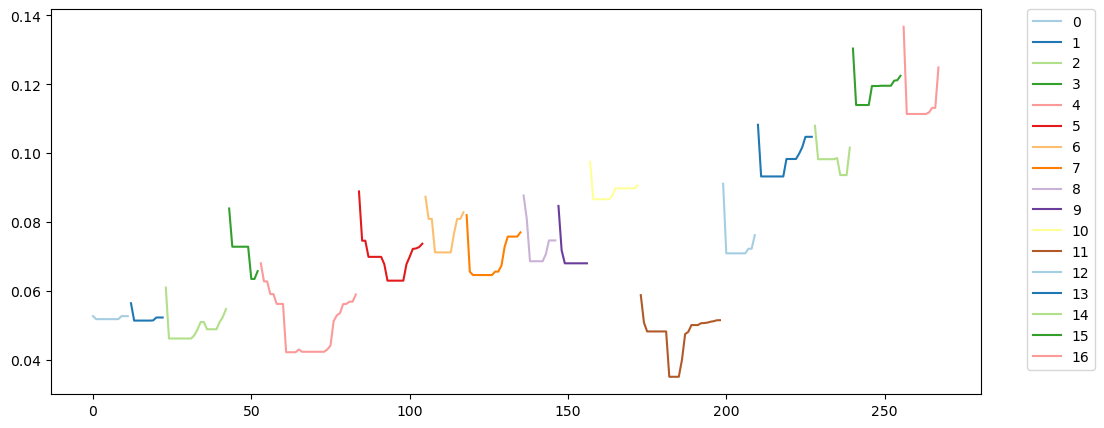

<Figure size 640x480 with 0 Axes>

In [43]:
## Extract the ordered reachability and cluster labels
reachability = optics_model.reachability_[optics_model.ordering_]
labels = optics_model.labels_[optics_model.ordering_]

## Remove the cases where the sample is not in a cluster
reachability = reachability[labels > -1]
labels = labels[labels > -1]

## Plot the graph
plt.figure(figsize=(12,5))
sns.lineplot(x=range(reachability[1:].shape[0]), y=reachability[1:], hue=labels[1:], legend="full", palette="Paired")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
plt.clf()

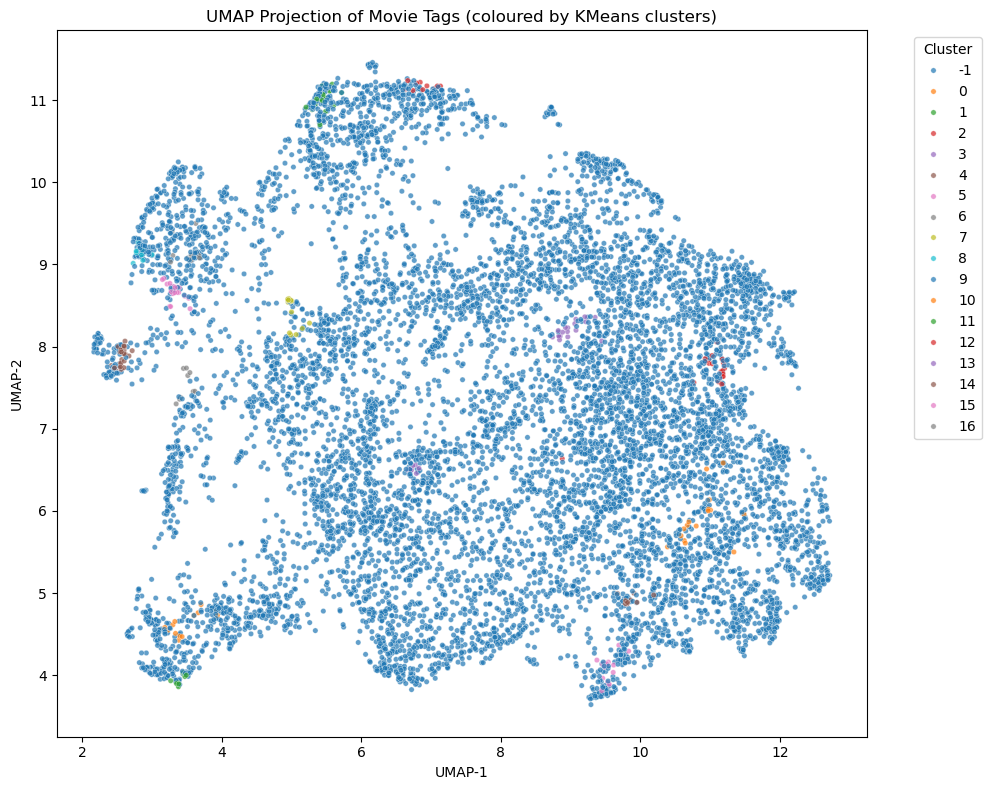

In [44]:
# Combine UMAP projection and cluster assignments
umap_df = pd.DataFrame(umap_embedding, columns=['UMAP-1', 'UMAP-2'], index=clustering_optics.index)
umap_df['cluster'] = clustering_optics['cluster']

# Plot UMAP with cluster colouring
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=umap_df,
    x='UMAP-1', y='UMAP-2',
    hue='cluster',
    palette='tab10',  # Up to 10 distinct colours
    s=15,
    alpha=0.7
)
plt.title('UMAP Projection of Movie Tags (coloured by KMeans clusters)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

After varying the `p` value, `min_samples` and the metric used, most cases result in all our data being in one singular cluster or lots of very small clusters with the majority of our data not being allocated a cluster. The reachability plot does not show a clear and continuous graph over the different clusters like we would like to see. With the majority of the data being considered noise. This is most likely due to the high dimensionality of the data.

> **Conclusion**
>
> Clustering on the user-tag data allowed us to explore whether films can be meaningfully grouped according to perceived themes, rather than conventional genre classifications. These tag-driven clusters aimed to capture audience sentiment and interpretation, offering a data-driven view of thematic structure in cinema.
>
> Multiple clustering methods were applied, including K-Means and OPTICS. K-Means proved to be the most tractable and interpretable method, consistently producing stable clusters when applied to the lower-dimensional PCA and UMAP projections. In contrast, OPTICS failed to extract coherent cluster structures in this context and could not allocate most data points, determining them as 'noise'.  
>
> KMeans clusters, when visualised via UMAP, revealed separable groupings of films, suggesting that user tags do encode some consistent thematic structure. However, these clusters may not always aligned with conventional genres, as themes and audience interpretation often cross genre boundaries. For example, clusters dominated by tags like *"thought-provoking"*, *"dark"* or *"female lead"* cut across drama, thriller, and sci-fi genres.
>
> Overall, while not all clustering methods were successful, the results from K-Means provide a useful basis for identifying latent thematic structures in film data. Future work may involve aligning these clusters with user rating behaviour or critical acclaim to evaluate their practical relevance.

## User based Reviews
---

As the tag data has not proven particularly useful for clustering, aside from offering potential insights into genre or thematic categories, the focus now shifts to user ratings. The goal is to develop a collaborative filtering system that leverages user review patterns to recommend films based on similarities in viewing behaviour and preferences. By identifying users with similar rating profiles, we aim to generate personalised recommendations that reflect the collective experience of the user base.

Given the massive scale of the dataset—containing approximately $28.5$ million ratings—careful attention must be paid to memory usage and computational efficiency. This necessitates the use of scalable algorithms and data structures, potentially including sparse matrices, approximate nearest neighbour methods, or dimensionality reduction techniques, to ensure feasibility and performance.

In [45]:
ratings

item_id  user_id  rating
0               5   997206     3.0
1              10   997206     4.0
2              13   997206     4.0
3              17   997206     5.0
4              21   997206     4.0
...           ...      ...     ...
28490111   104211   187144     1.5
28490112   104243   187144     3.5
28490113   104374   187144     3.5
28490114   104841   187144     3.0
28490115   104913   187144     4.0

[28490116 rows x 3 columns]

In [46]:
np.isnan(ratings).sum()

item_id    0
user_id    0
rating     0
dtype: int64

### Initial Exploritory Analysis
---

Let us consider what our User data shows, and any potential issues that could affect our process.

In [47]:
# Summary: average ratings per movie
movie_mean_ratings = ratings.groupby('item_id')['rating'].mean().sort_values(ascending=False)

movie_mean_with_titles = metadata[['item_id', 'title']].merge(
    movie_mean_ratings, on='item_id'
).rename(columns={'rating': 'mean_user_rating'})

# Top-rated
print(movie_mean_with_titles.sort_values('mean_user_rating', ascending=False).head(10))

# Lowest-rated
print(movie_mean_with_titles.sort_values('mean_user_rating').head(10))

       item_id                                              title  \
46061   171849                              Without Family (1984)   
66952   237015                              This Time Away (2019)   
58292   199618      BTS World Tour: Love Yourself in Seoul (2019)   
58285   199598                        In the Name of Honor (2015)   
24998   116108  The Secret Country: The First Australians Figh...   
32235   137052                           A Job to Kill For (2006)   
32240   137064                              Twisted Desire (1996)   
32247   137078                        Stranger in My House (1999)   
64363   217613                              Love in Design (2018)   
64345   217531   Deconstructing the Beatles' Abbey Road: Side One   

       mean_user_rating  
46061               5.0  
66952               5.0  
58292               5.0  
58285               5.0  
24998               5.0  
32235               5.0  
32240               5.0  
32247               5.0  
64363 

In [48]:
# Count number of ratings per user
ratings['user_id'].value_counts()

user_id
347565    34397
414405     9330
741204     9286
632423     8835
144113     8581
          ...  
340181        1
280170        1
314912        1
806305        1
580648        1
Name: count, Length: 247383, dtype: int64

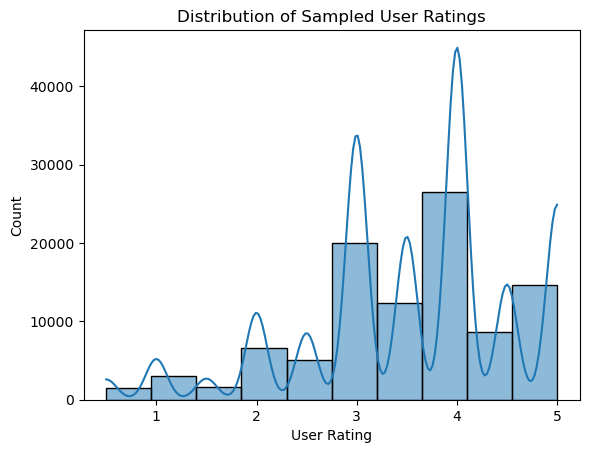

In [49]:
sampled_ratings = ratings['rating'].sample(n=100000, random_state=42)

sns.histplot(sampled_ratings, bins=10, kde=True)
plt.title("Distribution of Sampled User Ratings")
plt.xlabel("User Rating")
plt.ylabel("Count")
plt.show()

From the average user ratings, it does appear that the best and worst rated films may have very few ratings, and therefore skewed by this. From a small sample, the distribion or ratings (on 0 to 5 scale) seem to be what we would expect, negatively skewed with the modal rating around 3.5-4 ish.

### Data Preparation

As there is a lot of data, and we aim to cluster these users by their ratings, it would be easier and more accurate doing this on users with more ratings. Therefore, we will filter our data to only include users with `min_ratings`, we may vary this later depending on how our investigation goes. We will initially start with `min_ratings` = 30.

In [50]:
# Count ratings per user
user_rating_counts = ratings['user_id'].value_counts()

# Set threshold
min_ratings = 30

# Filter users
active_users = user_rating_counts[user_rating_counts >= min_ratings].index

# Keep only those users
filtered_ratings = ratings[ratings['user_id'].isin(active_users)]

filtered_ratings.shape

(26944003, 3)

This still gives my almost $27$ million users to use.

We will now separate into a train and test dataset. This is to save some users to test the approach later.

In [51]:
# Split users into training and test groups
unique_users = filtered_ratings['user_id'].unique()

# 70% users for training, 30% users for testing (cold-start scenario)
train_users, test_users = train_test_split(unique_users, test_size=0.3, random_state=42)

# Separate ratings into training and test sets based on users
train_ratings = filtered_ratings[filtered_ratings['user_id'].isin(train_users)]
test_ratings = filtered_ratings[filtered_ratings['user_id'].isin(test_users)]

# Verify the splits
print(f"Training set users: {train_ratings['user_id'].nunique()}, ratings: {len(train_ratings)}")
print(f"Test set users: {test_ratings['user_id'].nunique()}, ratings: {len(test_ratings)}")

train_ratings.head()

Training set users: 96859, ratings: 18901252
Test set users: 41512, ratings: 8042751


item_id  user_id  rating
233        1   667138     5.0
234        3   667138     4.0
235       11   667138     5.0
236       17   667138     5.0
237       28   667138     5.0

Due to the size of the user data we have, we need to be careful with how we can meaningfully represent it. Therefore, to allow for fast look up, and to help consider recommenders in the future, we will create a hash table, with each user being linked to a dictionary of the films they have rated and their ratings.

In [52]:
user_ratings_dict = defaultdict(dict)
for row in train_ratings.itertuples():
    user_ratings_dict[row.user_id][row.item_id] = row.rating

In [53]:
# Preview first 5 users and their ratings
for user, movie_ratings in islice(user_ratings_dict.items(), 5):
    print(f"User {user}:")
    print(f"  Rated {len(movie_ratings)} movies")
    print(f"  Sample: {dict(islice(movie_ratings.items(), 3))}")
    print()


User 667138:
  Rated 147 movies
  Sample: {1: 5.0, 3: 4.0, 11: 5.0}

User 226316:
  Rated 33 movies
  Sample: {10: 4.0, 19: 3.0, 47: 5.0}

User 273387:
  Rated 51 movies
  Sample: {1: 4.0, 3: 2.0, 9: 4.0}

User 485954:
  Rated 83 movies
  Sample: {1: 4.0, 6: 2.0, 10: 4.0}

User 648979:
  Rated 129 movies
  Sample: {10: 4.0, 16: 4.0, 19: 1.0}



In order to consider user-item preferences to help develop a recommender, we will create a sparse matrix based on user reviews. 

In [54]:
train_ratings = train_ratings.copy()

# Encode user and movie IDs to numeric indices
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

train_ratings['user_idx'] = user_encoder.fit_transform(train_ratings['user_id'])
train_ratings['item_idx'] = item_encoder.fit_transform(train_ratings['item_id'])

# Sparse matrix
user_item_matrix = csr_matrix(
    (train_ratings['rating'], (train_ratings['user_idx'], train_ratings['item_idx']))
)

print("Sparse matrix shape:", user_item_matrix.shape)

Sparse matrix shape: (96859, 63975)


> **Conclusion**
>
> Now we have cleaned our data, we can reduce the dimension of our sparse matrix in order to apply this to recommend films based on user ratings.
>
> It is evident that some films have no tag data. We hope that through a combination of user ratings and film metadata to be able to users.

### Dimensionality Reduction
---

Due to the high dimensionality fo this sparse matrix, we will use **Single Value Decomposition (SVD)** to reduce the dimension to discover latent user preferences. We will reduce to $50$ components initially, but may come back to review this later.

In [55]:
svd = TruncatedSVD(n_components=50, random_state=42)
%time user_factors = svd.fit_transform(user_item_matrix)
item_factors = svd.components_.T

print("User embeddings shape:", user_factors.shape)
print("Item embeddings shape:", item_factors.shape)

CPU times: total: 6.44 s
Wall time: 5.06 s
User embeddings shape: (96859, 50)
Item embeddings shape: (63975, 50)


In [56]:
movie_ids = item_encoder.inverse_transform(range(item_factors.shape[0]))

# Create DataFrame of item embeddings
item_factors_df = pd.DataFrame(item_factors, index=movie_ids)
item_factors_df.columns = [f'LF{i+1}' for i in range(item_factors.shape[1])]
item_factors_df.index.name = 'item_id'

print(item_factors_df.head())

              LF1       LF2       LF3       LF4       LF5       LF6       LF7  \
item_id                                                                         
1        0.080410 -0.015278  0.068134  0.016963  0.018116  0.094907 -0.029851   
2        0.034403 -0.010077  0.051273 -0.043109 -0.012875  0.009792 -0.002629   
3        0.012727 -0.020231  0.018950 -0.022405 -0.010479  0.000575 -0.003174   
4        0.002751 -0.006997  0.004898 -0.005094 -0.010738  0.001837 -0.004258   
5        0.011912 -0.016012  0.022467 -0.023214 -0.017055  0.007474 -0.012071   

              LF8       LF9      LF10  ...      LF41      LF42      LF43  \
item_id                                ...                                 
1       -0.045355  0.070605  0.022027  ...  0.147595  0.114845 -0.045862   
2       -0.050379  0.000422 -0.025725  ... -0.012731 -0.068954 -0.021126   
3        0.007653  0.023614  0.019693  ...  0.011528  0.018131  0.003128   
4        0.001593  0.005694  0.009340  ...  0.013921

## Collaborative Filtering on Users 
---

With these factors computed from each user, we can now create a *Collaborative Filtering System*. 
Let

$\hat{R} := \text{Predictions Matrix}$

$U := \text{User Matrix}$

$F := \text{Item Matrix}$

Consider user $u$ and item $i$
$$\hat{R}_{u,i} = U_u \cdot F_i$$
Therefore, each prediction is the dot product between the user vector and the item vector.

Therefore, we can theorectically produce a matrix of all recommendations by
$$\hat{R} = U \cdot F^T$$
However, due to the size of the matrices involved here, that is not possible, as seen below.

As our User matrix has $96859$ rows, and the Item matrix has $63975$ rows, my prediction matrix will be of shape $(96859, 63975)$. As we are using float64, there are 8 bytes per value, therefore
$$96859 \times 63975 \times 8 \approx 46.2 \text{ GiB}$$
This is above the standard RAM calabilities for home computers.

In [76]:
# predicted_ratings = user_factors @ item_factors.T

MemoryError: Unable to allocate 46.2 GiB for an array with shape (96859, 63975) and data type float64

Instead, we will compute these recommendations on demand for specific users, as this is just the dot product of the user and item vector.

In [77]:
def recommend_for_user(user_id, user_factors, item_factors, ratings, top_n=10):
    # Get internal user index
    user_index = user_encoder.transform([user_id])[0]
    
    # Predict scores for all items for that user
    scores = user_factors[user_index] @ item_factors.T
    
    # Mask out already-rated items
    seen = user_item_matrix[user_index].nonzero()[1]
    scores[seen] = -np.inf
    
    # Get top-N
    top_item_indices = np.argsort(scores)[-top_n:][::-1]
    top_item_ids = item_encoder.inverse_transform(top_item_indices)
    
    return top_item_ids

Considers a specific user, like the ones sampled earlier

User 667138:
  Rated 147 movies


User 226316:
  Rated 33 movies


User 273387:
  Rated 51 movies


User 485954:
  Rated 83 movies


User 648979:
  Rated 129 movies

We will see if this can recommend movies.

In [78]:
combined_movie_features = movie_features_pca.merge(item_factors_df, on='item_id', how='inner')

%time all_movie_features = combined_movie_features.merge(genre, on='item_id', how='inner')

# Move 'Genres'
cols = all_movie_features.columns.tolist()
cols.insert(6, cols.pop(cols.index('genres')))
all_movie_features = all_movie_features[cols]


all_movie_features.head(10)

CPU times: total: 62.5 ms
Wall time: 50.2 ms


title       directedBy  \
0                    Toy Story (1995)    John Lasseter   
1                      Jumanji (1995)     Joe Johnston   
2             Grumpier Old Men (1995)    Howard Deutch   
3            Waiting to Exhale (1995)  Forest Whitaker   
4  Father of the Bride Part II (1995)    Charles Shyer   
5                         Heat (1995)     Michael Mann   
6                      Sabrina (1995)   Sydney Pollack   
7                 Tom and Huck (1995)     Peter Hewitt   
8                 Sudden Death (1995)      Peter Hyams   
9                    GoldenEye (1995)  Martin Campbell   

                                            starring  avgRating  imdbId  \
0  Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...   0.778292  114709   
1  Jonathan Hyde, Bradley Pierce, Robin Williams,...   0.653210  113497   
2  Jack Lemmon, Walter Matthau, Ann-Margret , Sop...   0.634292  113228   
3  Angela Bassett, Loretta Devine, Whitney Housto...   0.573648  114885   
4  Steve Martin, Martin Short, Diane Keaton, Kimb...   0.615240  113041   
5  Robert De Niro, Al Pacino, Val Kilmer, Jon Voi...   0.771098  113277   
6  Harrison Ford, Greg Kinnear, Nancy Marchand, J...   0.674488  114319   
7  Jonathan Taylor Thomas, Brad Renfro, Eric Schw...   0.623356  112302   
8  Raymond J. Barry, Powers Boothe, Jean-Claude V...   0.600484  114576   
9  Pierce Brosnan, Sean Bean, Famke Janssen, Izab...   0.686680  113189   

   item_id                                       genres  \
0        1  Adventure|Animation|Children|Comedy|Fantasy   
1        2                   Adventure|Children|Fantasy   
2        3                               Comedy|Romance   
3        4                         Comedy|Drama|Romance   
4        5                                       Comedy   
5        6                        Action|Crime|Thriller   
6        7                               Comedy|Romance   
7        8                           Adventure|Children   
8        9                                       Action   
9       10                    Action|Adventure|Thriller   

                                               theme       PC1       PC2  ...  \
0  High-octane action and suspense, Family-friend...  0.555630  2.780478  ...   
1            Family-friendly classics and animations -2.183376  1.431176  ...   
2                      Fantasy and surreal mythology -2.441146 -0.317177  ...   
3               Post-apocalyptic dark romantic crime -2.010603 -1.445083  ...   
4                      Fantasy and surreal mythology -2.571122 -0.745268  ...   
5  Critically acclaimed, artistic, emotional dram...  3.370178  2.587224  ...   
6                         Erotic and romantic themes -1.931331 -1.100723  ...   
7            Children’s animation and fantasy worlds -2.574883 -1.180084  ...   
8                Dark, violent, disturbing thrillers -2.981857 -0.100481  ...   
9                    High-octane action and suspense -1.558499  2.428740  ...   

   Film-Noir  Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  \
0          0       0     0        0        0        0       0         0    0   
1          0       0     0        0        0        0       0         0    0   
2          0       0     0        0        0        1       0         0    0   
3          0       0     0        0        0        1       0         0    0   
4          0       0     0        0        0        0       0         0    0   
5          0       0     0        0        0        0       0         1    0   
6          0       0     0        0        0        1       0         0    0   
7          0       0     0        0        0        0       0         0    0   
8          0       0     0        0        0        0       0         0    0   
9          0       0     0        0        0        0       0         1    0   

   Western  
0        0  
1        0  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0  



In [79]:
user_sample = [667138,226316,273387,485954,648979]

for user in user_sample:
    user_top_five = recommend_for_user(user, user_factors, item_factors, ratings, top_n=5)

    print(f"\nUser: {user}\n🎯 Recommended movies:")

    for item_id in user_top_five:
        movie_row = all_movie_features[all_movie_features['item_id'] == item_id]
        
        title = movie_row['title'].values[0] if not movie_row['title'].isnull().any() else "Unknown"
        genres = movie_row['genres'].values[0] if not movie_row['genres'].isnull().any() else "Unknown"
        theme = movie_row['theme'].values[0] if not movie_row['theme'].isnull().any() else "Unknown"
        
        print(f"- {title} | Genres: {genres}\n  Theme: {theme}")


User: 667138
🎯 Recommended movies:
- Fugitive, The (1993) | Genres: Thriller
  Theme: High-octane action and suspense
- Ghost (1990) | Genres: Comedy|Drama|Fantasy|Romance|Thriller
  Theme: High-octane action and suspense
- Princess Bride, The (1987) | Genres: Action|Adventure|Comedy|Fantasy|Romance
  Theme: High-octane action and suspense, Family-friendly classics and animations
- Clear and Present Danger (1994) | Genres: Action|Crime|Drama|Thriller
  Theme: Teen school drama and secrets
- Philadelphia (1993) | Genres: Drama
  Theme: Critically acclaimed, artistic, emotional dramas

User: 226316
🎯 Recommended movies:
- Die Hard: With a Vengeance (1995) | Genres: Action|Crime|Thriller
  Theme: High-octane action and suspense
- Braveheart (1995) | Genres: Action|Drama|War
  Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense
- Apollo 13 (1995) | Genres: Adventure|Drama|IMAX
  Theme: High-octane action and suspense
- Batman Forever (1995) | Genres: A

So, we have successfully been able to create a recommendation on users given their ratings. However, we are not currently sure how good these recommendations are and we are yet to use our PCA from before to consider a Hybrid recommender.

One issue we need to highlight with this current recommender, is depite these 5 users being randomly chosen, their lists of recommended films are quite similar with the following films occuring in multiple recommendation lists:
- Die Hard: With a Vengeance (1995)
- Interview with the Vampire: The Vampire Chronicles (1994)
- Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
- While You Were Sleeping (1995)

The other films are all very well-known, box-office and critically acclaimed films. Therefore, there maybe a *cold-start* issue with some of our films having few reviews, and therefore not be recommended.

In [80]:
# List of repeated film titles
repeated_titles = [
    "Die Hard: With a Vengeance (1995)",
    "Twelve Monkeys (a.k.a. 12 Monkeys) (1995)",
    "Interview with the Vampire: The Vampire Chronicles (1994)",
    "While You Were Sleeping (1995)"
]

# Find item_ids for these films
matched_items = metadata[metadata['title'].isin(repeated_titles)][['item_id', 'title']]

# Count number of ratings for each item_id
rating_counts = ratings.groupby('item_id')['rating'].count().reset_index(name='num_ratings')

# Merge to show title, item_id, and count
film_stats = matched_items.merge(rating_counts, on='item_id', how='left')

print(film_stats)

   item_id                                              title  num_ratings
0       32          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)        55217
1      165                  Die Hard: With a Vengeance (1995)        41417
2      253  Interview with the Vampire: The Vampire Chroni...        31487
3      339                     While You Were Sleeping (1995)        26032


As suspected, these films have a very large number of ratings, which is possibly why they were recommended.

In [81]:
def not_recommend_for_user(user_id, user_factors, item_factors, ratings, top_n=10):
    # Get internal user index
    user_index = user_encoder.transform([user_id])[0]
    
    # Predict scores for all items for that user
    scores = user_factors[user_index] @ item_factors.T
    
    # Mask out already-rated items
    seen = user_item_matrix[user_index].nonzero()[1]
    scores[seen] = -np.inf
    
    # Get bottom-N
    bottom_item_indices = np.argsort(scores)[:top_n]
    bottom_item_ids = item_encoder.inverse_transform(bottom_item_indices)
    
    return bottom_item_ids

In [82]:
user_sample = [667138,226316,273387,485954,648979]

for user in user_sample:
    user_bottom_five = not_recommend_for_user(user, user_factors, item_factors, ratings, top_n=5)

    # Link back to metadata for movie titles, preserving order of recommendation
    not_recommended_titles = [metadata.loc[metadata['item_id'] == iid, 'title'].values[0] for iid in user_bottom_five]
    
    print(f"User: {user}\nNOT Recommended movies:")
    for title in not_recommended_titles:
        print(f"- {title}")
    print()

User: 667138
NOT Recommended movies:
- Toy Story (1995)
- Restoration (1995)
- Happy Gilmore (1996)
- Muppet Treasure Island (1996)
- Braveheart (1995)

User: 226316
NOT Recommended movies:
- Johnny Mnemonic (1995)
- Dirty Dancing (1987)
- Titan A.E. (2000)
- Walk in the Clouds, A (1995)
- True Romance (1993)

User: 273387
NOT Recommended movies:
- Toy Story (1995)
- GoldenEye (1995)
- Money Train (1995)
- Get Shorty (1995)
- Sudden Death (1995)

User: 485954
NOT Recommended movies:
- Toy Story (1995)
- Get Shorty (1995)
- Braveheart (1995)
- Basketball Diaries, The (1995)
- Apollo 13 (1995)

User: 648979
NOT Recommended movies:
- Bowling for Columbine (2002)
- Birdcage, The (1996)
- Basketball Diaries, The (1995)
- Man Without a Face, The (1993)
- Mrs. Doubtfire (1993)



AI-generated code: Created list of `not_recommended_films`

Prompt used:
"Put these films into a defined list with no repeats" + Output from previous cell.

Tool: ChatGPT (OpenAI), Aug 2025
Note: All AI-generated content has been reviewed and interpreted by me to ensure alignment with the goals of the project and accurate domain representation.

In [83]:
not_recommended_films = {
    "Toy Story (1995)",
    "My Fellow Americans (1996)",
    "Mars Attacks! (1996)",
    "Jerry Maguire (1996)",
    "City Slickers II: The Legend of Curly's Gold (1994)",
    "Muppet Treasure Island (1996)",
    "Boxing Helena (1993)",
    "Cliffhanger (1993)",
    "Ben-Hur (1959)",
    "Batman (1989)",
    "Beauty and the Beast (1991)",
    "Léon: The Professional (a.k.a. The Professional) (Léon) (1994)",
    "Outbreak (1995)",
    "Rock, The (1996)",
    "Crimson Tide (1995)",
    "Clockers (1995)",
    "Firm, The (1993)",
    "Cops and Robbersons (1994)",
    "Naked Gun 33 1/3: The Final Insult (1994)",
    "Maverick (1994)",
    "Mask, The (1994)",
    "Braveheart (1995)"
}

# Find item_ids for these films
matched_items = metadata[metadata['title'].isin(not_recommended_films)][['item_id', 'title']]

# Count number of ratings for each item_id
rating_counts = ratings.groupby('item_id')['rating'].count().reset_index(name='num_ratings')

# Merge to show title, item_id, and count
film_stats = matched_items.merge(rating_counts, on='item_id', how='left')

print(film_stats)

    item_id                                              title  num_ratings
0         1                                   Toy Story (1995)        68884
1       107                      Muppet Treasure Island (1996)         8153
2       110                                  Braveheart (1995)        69190
3       159                                    Clockers (1995)         2492
4       161                                Crimson Tide (1995)        26410
5       292                                    Outbreak (1995)        29099
6       293  Léon: The Professional (a.k.a. The Professiona...        36962
7       367                                   Mask, The (1994)        38904
8       368                                    Maverick (1994)        19044
9       370          Naked Gun 33 1/3: The Final Insult (1994)        17032
10      427                               Boxing Helena (1993)         3531
11      432  City Slickers II: The Legend of Curly's Gold (...        13982
12      434 

This is a suprising result, as we were expecting that the least recommended films would be films with few user ratings, and be quite obscure films. However, this list is quite specific to our users and all the films have many ratings.

However, without the context of the film, the genre and our 'themes' found earlier, we believe we can make these recommenders better. For example, `user 226316` has been recommended *Batman Forever* but will not be recommended *Batman*, which does not make a great deal of sense, but is something that our 'themes' definitely could help with. 

> **Conclusion**
>
> We have determined a system and approach to recommend films based on user reviews, so that people can be recommended films that similar users have enjoyed.

## Clustering Films by User Data
---

Considering whether these rating can be clustered into groups will give us a greated understanding of how these algorithms are working, and the connections between films and users.

If successful, we could use this clustering to group similar user preferences to aid in recommendations, and to help with users with little data.

In [84]:
# Merge on item_id
combined_movie_features = movie_features_pca.merge(item_factors_df, on='item_id', how='inner')

# Drop rows with missing values, just in case
combined_movie_features = combined_movie_features.dropna()

combined_movie_features.head(10)

title       directedBy  \
0                    Toy Story (1995)    John Lasseter   
1                      Jumanji (1995)     Joe Johnston   
2             Grumpier Old Men (1995)    Howard Deutch   
3            Waiting to Exhale (1995)  Forest Whitaker   
4  Father of the Bride Part II (1995)    Charles Shyer   
5                         Heat (1995)     Michael Mann   
6                      Sabrina (1995)   Sydney Pollack   
7                 Tom and Huck (1995)     Peter Hewitt   
8                 Sudden Death (1995)      Peter Hyams   
9                    GoldenEye (1995)  Martin Campbell   

                                            starring  avgRating  imdbId  \
0  Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...   0.778292  114709   
1  Jonathan Hyde, Bradley Pierce, Robin Williams,...   0.653210  113497   
2  Jack Lemmon, Walter Matthau, Ann-Margret , Sop...   0.634292  113228   
3  Angela Bassett, Loretta Devine, Whitney Housto...   0.573648  114885   
4  Steve Martin, Martin Short, Diane Keaton, Kimb...   0.615240  113041   
5  Robert De Niro, Al Pacino, Val Kilmer, Jon Voi...   0.771098  113277   
6  Harrison Ford, Greg Kinnear, Nancy Marchand, J...   0.674488  114319   
7  Jonathan Taylor Thomas, Brad Renfro, Eric Schw...   0.623356  112302   
8  Raymond J. Barry, Powers Boothe, Jean-Claude V...   0.600484  114576   
9  Pierce Brosnan, Sean Bean, Famke Janssen, Izab...   0.686680  113189   

   item_id                                              theme       PC1  \
0        1  High-octane action and suspense, Family-friend...  0.555630   
1        2            Family-friendly classics and animations -2.183376   
2        3                      Fantasy and surreal mythology -2.441146   
3        4               Post-apocalyptic dark romantic crime -2.010603   
4        5                      Fantasy and surreal mythology -2.571122   
5        6  Critically acclaimed, artistic, emotional dram...  3.370178   
6        7                         Erotic and romantic themes -1.931331   
7        8            Children’s animation and fantasy worlds -2.574883   
8        9                Dark, violent, disturbing thrillers -2.981857   
9       10                    High-octane action and suspense -1.558499   

        PC2       PC3  ...      LF41      LF42      LF43      LF44      LF45  \
0  2.780478 -4.072990  ...  0.147595  0.114845 -0.045862 -0.090775  0.179575   
1  1.431176 -1.661436  ... -0.012731 -0.068954 -0.021126  0.018359  0.021799   
2 -0.317177 -0.769501  ...  0.011528  0.018131  0.003128 -0.005145  0.003838   
3 -1.445083 -0.995050  ...  0.013921 -0.001739 -0.006546 -0.003902 -0.000947   
4 -0.745268 -1.512939  ...  0.017017  0.012169 -0.012796 -0.010482  0.000946   
5  2.587224 -0.286533  ... -0.037809 -0.018699  0.049837  0.020586 -0.014289   
6 -1.100723 -1.406837  ...  0.011643  0.012974 -0.003209 -0.022387 -0.016904   
7 -1.180084 -0.805802  ...  0.013867 -0.006856 -0.005471 -0.001441  0.001252   
8 -0.100481  0.663575  ...  0.008074  0.000124 -0.001992  0.011811  0.008662   
9  2.428740 -0.144614  ... -0.028065 -0.001721 -0.028796  0.002142 -0.059019   

       LF46      LF47      LF48      LF49      LF50  
0  0.044325  0.073270 -0.035833 -0.001551 -0.060615  
1 -0.016996 -0.008774 -0.035311  0.043477 -0.059578  
2  0.017906 -0.017646  0.015352  0.014176 -0.002964  
3  0.011636 -0.004014  0.012558  0.003076 -0.008861  
4  0.028967 -0.016584  0.014157 -0.005569 -0.005507  
5 -0.001513  0.001838 -0.050963 -0.018427  0.055668  
6  0.006082  0.005622  0.031629  0.002940  0.017659  
7  0.006997 -0.005472 -0.003798  0.002899 -0.002927  
8  0.009591 -0.009645 -0.009699  0.001275  0.013917  
9  0.001100  0.027389 -0.056197 -0.037222  0.015746  

[10 rows x 87 columns]

### OPTICS
---

To assist with **OPTICS**, scaling is often required. The PCA values are scaled and normaised and should follow the distribution
$$\text{PC}_i \sim \mathcal{N}(0,1)$$
However, our Latent features are not, as the SVD does not center or scale these values. As we combine all these factors, it may be best to scale all values to ensure equal weighting across Principal Components and Latent Features, so that user reviews and tags are considered equally. 

In [85]:
# Extract just the combined features
feature_cols = [col for col in combined_movie_features.columns if col.startswith('PC') or col.startswith('LF')]
all_features = combined_movie_features[feature_cols].dropna()

# Scale features
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)

In [86]:
optics_model = OPTICS(min_samples=20, metric='cosine')
%time optics_model.fit(all_features_scaled)

# Assign cluster labels
combined_features_optics = combined_movie_features.loc[all_features.index].copy()
combined_features_optics['optics_cluster'] = optics_model.labels_

# Summary
cluster_summary = combined_features_optics.groupby('optics_cluster')['item_id'].agg(['count'])
print(cluster_summary.sort_values('optics_cluster', ascending=True))

CPU times: total: 1min 7s
Wall time: 1min 2s
                count
optics_cluster       
-1               9606
 0                 37
 1                 37
 2                 20
 3                 30


C:\Users\Liam\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


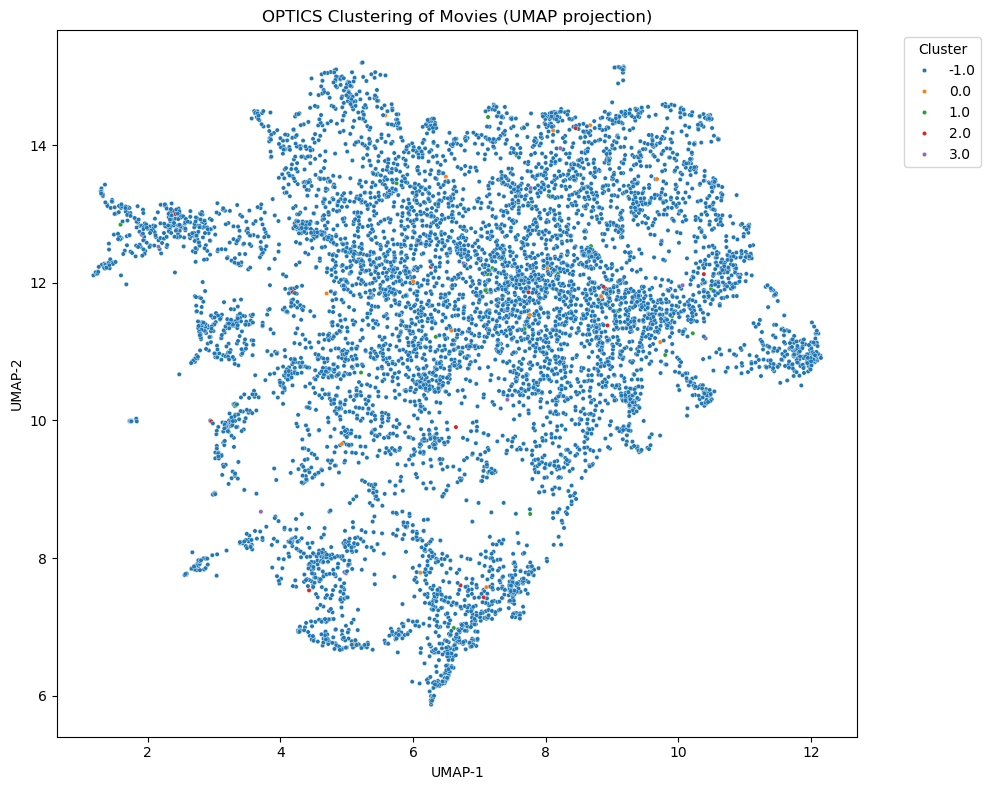

In [87]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(all_features_scaled)

umap_df = pd.DataFrame(embedding, columns=['UMAP-1', 'UMAP-2'])
umap_df['cluster'] = combined_features_optics['optics_cluster']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=umap_df, x='UMAP-1', y='UMAP-2', hue='cluster', palette='tab10', s=10)
plt.title('OPTICS Clustering of Movies (UMAP projection)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

As with the PCA attempt at clustering has again been unsuccessful. This may be due to the same reasons as before. Therefore, it may be best to use our Latent Feactures only for analysis and not as support for any clustering or similarity.

We have varied the parameters of of our *OPTICS* model, when considering a higher `min_samples`, we got 1 single cluster, when varying the metric, we achieved similar results.

In [88]:
# Extract just the combined features
lf_cols = [col for col in combined_movie_features.columns if col.startswith('LF')]

lf_features = combined_movie_features[lf_cols]

# Scale
scaler = StandardScaler()
lf_features_scaled = scaler.fit_transform(lf_features)

In [89]:
optics_model = OPTICS(min_samples=10, metric='cosine')
%time optics_model.fit(lf_features_scaled)

# Add cluster labels
lf_features_optics = combined_movie_features.copy() 
lf_features_optics['optics_cluster'] = optics_model.labels_

cluster_summary = lf_features_optics.groupby('optics_cluster')['item_id'].agg(['count'])
print(cluster_summary.sort_values('optics_cluster', ascending=True))

CPU times: total: 46.9 s
Wall time: 42.2 s
                count
optics_cluster       
-1               9288
 0                 29
 1                 10
 2                 16
 3                 13
 4                 12
 5                 11
 6                 28
 7                 18
 8                 13
 9                 18
 10                11
 11                27
 12                24
 13                22
 14                14
 15                15
 16                18
 17                43
 18                10
 19                13
 20                38
 21                11
 22                10
 23                18


C:\Users\Liam\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


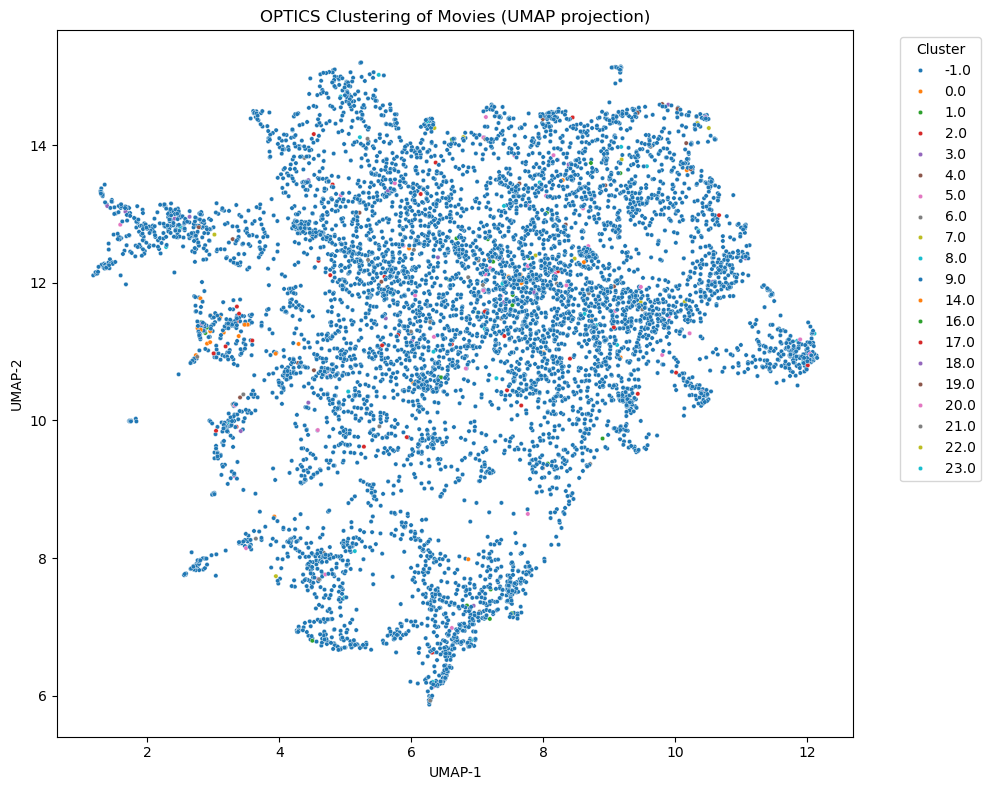

In [90]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(all_features_scaled)

umap_df = pd.DataFrame(embedding, columns=['UMAP-1', 'UMAP-2'])
umap_df['cluster'] = lf_features_optics['optics_cluster']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=umap_df, x='UMAP-1', y='UMAP-2', hue='cluster', palette='tab10', s=10)
plt.title('OPTICS Clustering of Movies (UMAP projection)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

As **OPTICS** continues to be ineffective in clustering the data and sees the majority of our data as 'noise', we will now consider **HDBSCAN**. This may prove better due to the dense nature of the data.

### HDBSCAN
---

Given the previous limitations of OPTICS and K-Means, we will now consider Hierarchical Density-Based Spatial Clustering of Applications with Noise (**HDBSCA**) as a more flexible and robust approach. We hope that this is more effective due to the higher dimensionality of our data and the possible noise found earlier.

In [94]:
%time hdbscan_model = HDBSCAN(min_cluster_size=20, metric='cosine')
labels = hdbscan_model.fit_predict(lf_features_scaled)

# Add to DataFrame
lf_features_hdbscan = combined_movie_features.copy() 
lf_features_hdbscan['hdbscan_cluster'] = labels

cluster_summary = lf_features_hdbscan.groupby('hdbscan_cluster')['item_id'].agg(['count'])
print(cluster_summary.sort_values('hdbscan_cluster', ascending=True))

CPU times: total: 0 ns
Wall time: 36 μs
                 count
hdbscan_cluster       
-1                5266
 0                  24
 1                  42
 2                4366
 3                  32


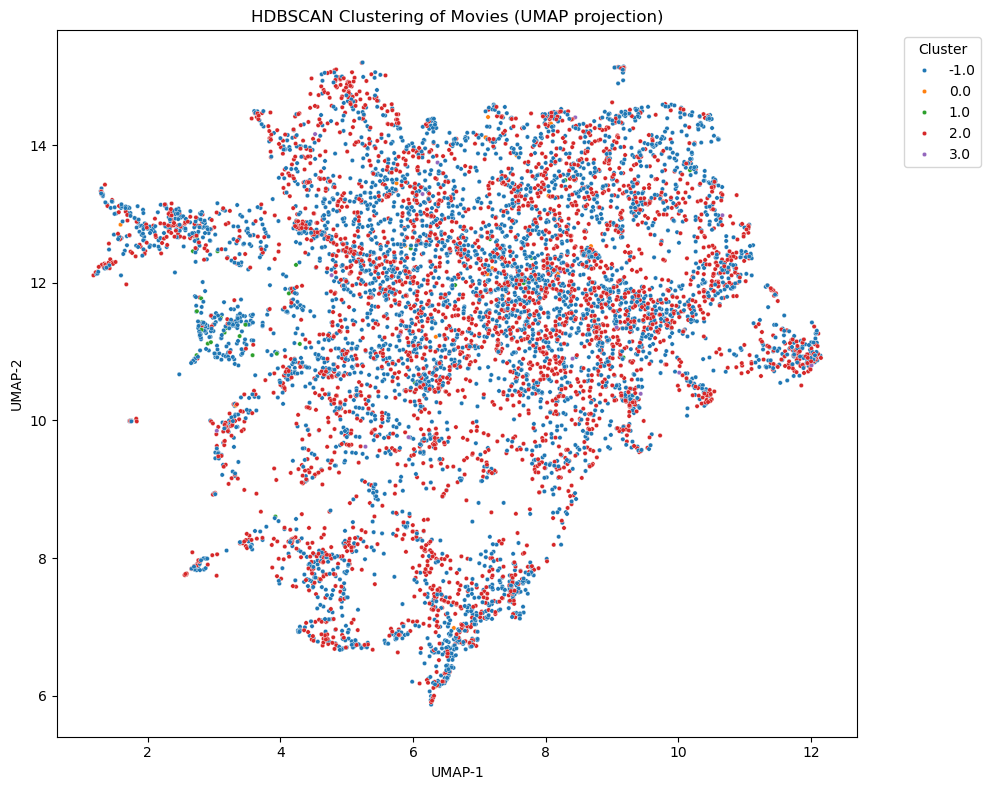

In [95]:
umap_df = pd.DataFrame(embedding, columns=['UMAP-1', 'UMAP-2'])
umap_df['cluster'] = lf_features_hdbscan['hdbscan_cluster']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=umap_df, x='UMAP-1', y='UMAP-2', hue='cluster', palette='tab10', s=10)
plt.title('HDBSCAN Clustering of Movies (UMAP projection)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

As with previous attempts, we have varied the parameters, this result was the best interms of enough valid, and well sized clusters.

> **Conclusion**
> Once again, clustering does not seem possible with this data and is not producing anything useful, we have vew few clusters, most of which are very small, and the majority of data is not assigned a cluster. Therefore, we will pivot and consider instead a similarity search to support with combing together user based tags, user rating and meta data in order to help with our recommender.

## Creation of a Recommender System
---

We will now combine all of what we have learnt to dry and create a two-tower recommendation system. We will be incorporating further metadata from films to support this. Our towers will be formed from metadata and user provided data

**Item Tower**
This will be information about our films, which should help with the cold start issue with new films. It will be comprised of
- PCA: Principal Components from user-ranked 'tag' data. This gives further themes and commonality between films
- Latent Factors: From SVD on user ratings of films. Collaborative filtering to support user-item recommendations
- Metadata: *'Genre'* will be used to further support recommendations

**User Tower**
- Specific user ratings on films. To provide initial information for recommendations.

Later, we will attempt to create a cold-start approach to be able to create a user-profile to assist in meaningful recomendations. 

This will give us a balanced approach to recommending films for users.

### Hybrid Similarity Search - Item Tower
---

Now we will be constructing a hybrid simliarity system, which will use the **PCA** on the tags and the **SVD** on the user ratings. Therefore, creating a system where user data (both tags and ratings) can be used to find simliarity. Due to the existance of categorical data, we will use **cosine similarity** for these factors, but will also consider a **Jaccard Similariy** for the genres. We will initially weight these as
$$\text{Score} = 0.3 \times \text{PC} + 0.3 \times \text{LF} + 0.4 \times \text{Genre}$$
Again, we may consider this weighting based on results.

In [96]:
pc_cols = [col for col in all_movie_features.columns if col.startswith('PC')]
lf_cols = [col for col in all_movie_features.columns if col.startswith('LF')]

def hybrid_similarity(movie_idx1, movie_idx2):
    """Calculates a similarity score by weighing, returns score"""
    # Extract rows
    m1 = all_movie_features.loc[movie_idx1]
    m2 = all_movie_features.loc[movie_idx2]

    # Drop rows with NaNs in critical fields
    if (
        m1[pc_cols].isnull().any()
        or m2[pc_cols].isnull().any()
        or m1[lf_cols].isnull().any()
        or m2[lf_cols].isnull().any()
        or m1[genre_cols].isnull().any()
        or m2[genre_cols].isnull().any()
    ):
        return -1
    
    # Cosine similarity for PC and LF vectors
    cos_pc = cosine_similarity([m1[pc_cols]], [m2[pc_cols]])[0, 0]
    cos_lf = cosine_similarity([m1[lf_cols]], [m2[lf_cols]])[0, 0]
    
    # Jaccard similarity for genre binary vectors
    jaccard_genre = 1 - jaccard(m1[genre_cols], m2[genre_cols])
    
    # Weighted combination
    score = 0.3 * cos_pc + 0.3 * cos_lf + 0.4 * jaccard_genre
    return score

In [97]:
def recommend_similar_movies(target_item_id, top_n=5):
    """Input movie, returns top n similar movies"""
    target_idx = all_movie_features[all_movie_features['item_id'] == target_item_id].index[0]
    
    similarity = []
    for idx, row in all_movie_features.iterrows():
        if idx == target_idx:
            continue
        sim_score = hybrid_similarity(target_idx, idx)
        similarity.append((row['item_id'], sim_score))
    
    # Sort and return top-N
    top_items = sorted(similarity, key=lambda x: x[1], reverse=True)[:top_n]
    return top_items

We will now test our recommendations based on the first 10 films of our data.

In [99]:
for i in range(10):
    movie = all_movie_features.iloc[i]
    item_id = movie['item_id']
    title = movie['title']
    genres = movie['genres']
    
    print(f"\n🎬 Movie: {title}  |  Genres: {genres}")
    print("Recommended movies:")

    %time top_recs = recommend_similar_movies(target_item_id=item_id, top_n=5)
    
    for rec_id, score in top_recs:
        # Lookup full info for the recommended movie
        rec_row = all_movie_features[all_movie_features['item_id'] == rec_id].iloc[0]
        rec_title = rec_row['title']
        rec_genres = rec_row['genres']
        print(f" - {rec_title}  |  Genres: {rec_genres}  (score: {score:.3f})")


🎬 Movie: Toy Story (1995)  |  Genres: Adventure|Animation|Children|Comedy|Fantasy
Recommended movies:
CPU times: total: 42.2 s
Wall time: 42.6 s
 - Toy Story 2 (1999)  |  Genres: Adventure|Animation|Children|Comedy|Fantasy  (score: 0.882)
 - Monsters, Inc. (2001)  |  Genres: Adventure|Animation|Children|Comedy|Fantasy  (score: 0.818)
 - Toy Story 3 (2010)  |  Genres: Adventure|Animation|Children|Comedy|Fantasy|IMAX  (score: 0.731)
 - Bug's Life, A (1998)  |  Genres: Adventure|Animation|Children|Comedy  (score: 0.727)
 - Finding Nemo (2003)  |  Genres: Adventure|Animation|Children|Comedy  (score: 0.723)

🎬 Movie: Jumanji (1995)  |  Genres: Adventure|Children|Fantasy
Recommended movies:
CPU times: total: 42.9 s
Wall time: 43 s
 - Indian in the Cupboard, The (1995)  |  Genres: Adventure|Children|Fantasy  (score: 0.812)
 - NeverEnding Story III, The (1994)  |  Genres: Adventure|Children|Fantasy  (score: 0.738)
 - NeverEnding Story, The (1984)  |  Genres: Adventure|Children|Fantasy  (score

AI-generated code snippet:
The Python loop displaying the title and genre of a selected movie alongside its top 5 hybrid similarity-based recommendations (including their genres and similarity scores) was generated using ChatGPT.

Prompt used:
“Print the first 10 movies with their 'title' and 'genre', and show their top 5 recommended movies with 'genres' and 'similarity scores'.” + attempted code and variables used.

Tool: ChatGPT (OpenAI), August 2025
Note: All AI-generated code was reviewed and adapted by me to ensure accuracy, clarity, and alignment with the project’s methodology.

I am concerned that this does seem to weight the genre quite high, although, it is clear that the *tags* have an influence, as although *James Bond* films are all *Action*, a very common genre, the `007` tag has ensured that other *James Bond* films have been recommended for *GoldenEye*.

However, we will still trial this with a different weighting. Let us instead consider
$$\text{Score} = 0.4 \times \text{PC} + 0.4 \times \text{LF} + 0.2 \times \text{Genre}$$

In [100]:
def hybrid_similarity(movie_idx1, movie_idx2):
    """Calculates a similarity score by weighing, returns score"""
    # Extract rows
    m1 = all_movie_features.loc[movie_idx1]
    m2 = all_movie_features.loc[movie_idx2]

    # Drop rows with NaNs in critical fields
    if (
        m1[pc_cols].isnull().any()
        or m2[pc_cols].isnull().any()
        or m1[lf_cols].isnull().any()
        or m2[lf_cols].isnull().any()
        or m1[genre_cols].isnull().any()
        or m2[genre_cols].isnull().any()
    ):
        return -1
    
    # Cosine similarity for PC and LF vectors
    cos_pc = cosine_similarity([m1[pc_cols]], [m2[pc_cols]])[0, 0]
    cos_lf = cosine_similarity([m1[lf_cols]], [m2[lf_cols]])[0, 0]
    
    # Jaccard similarity for genre binary vectors
    jaccard_genre = 1 - jaccard(m1[genre_cols], m2[genre_cols])
    
    # Weighted combination
    score = 0.4 * cos_pc + 0.4 * cos_lf + 0.2 * jaccard_genre
    return score

In [101]:
for i in range(10):
    movie = all_movie_features.iloc[i]
    item_id = movie['item_id']
    title = movie['title']
    genres = movie['genres']
    
    print(f"\n🎬 Movie: {title}  |  Genres: {genres}")
    print("Recommended movies:")

    top_recs = recommend_similar_movies(target_item_id=item_id, top_n=5)
    
    for rec_id, score in top_recs:
        # Lookup full info for the recommended movie
        rec_row = all_movie_features[all_movie_features['item_id'] == rec_id].iloc[0]
        rec_title = rec_row['title']
        rec_genres = rec_row['genres']
        print(f" - {rec_title}  |  Genres: {rec_genres}  (score: {score:.3f})")


🎬 Movie: Toy Story (1995)  |  Genres: Adventure|Animation|Children|Comedy|Fantasy
Recommended movies:
 - Toy Story 2 (1999)  |  Genres: Adventure|Animation|Children|Comedy|Fantasy  (score: 0.842)
 - Monsters, Inc. (2001)  |  Genres: Adventure|Animation|Children|Comedy|Fantasy  (score: 0.757)
 - Bug's Life, A (1998)  |  Genres: Adventure|Animation|Children|Comedy  (score: 0.703)
 - Toy Story 3 (2010)  |  Genres: Adventure|Animation|Children|Comedy|Fantasy|IMAX  (score: 0.698)
 - Finding Nemo (2003)  |  Genres: Adventure|Animation|Children|Comedy  (score: 0.697)

🎬 Movie: Jumanji (1995)  |  Genres: Adventure|Children|Fantasy
Recommended movies:
 - Indian in the Cupboard, The (1995)  |  Genres: Adventure|Children|Fantasy  (score: 0.749)
 - Casper (1995)  |  Genres: Adventure|Children  (score: 0.728)
 - Honey, I Shrunk the Kids (1989)  |  Genres: Adventure|Children|Comedy|Fantasy|Sci-Fi  (score: 0.680)
 - NeverEnding Story III, The (1994)  |  Genres: Adventure|Children|Fantasy  (score: 0.

Comparing these two weightings of recommendations:

| 🎬 Movie Title                     | Top-5 Overlap | Notes                                                                 |
|-----------------------------------|---------------|------------------------------------------------------------------------|
| Toy Story (1995)                  | 5/5           | Same films, slightly reordered — genre very dominant                   |
| Jumanji (1995)                    | 3/5           | Some overlap; less genre-heavy results at lower genre weight          |
| Grumpier Old Men (1995)           | 2/5           | Genre effect strong — new list includes more varied comedy/romance    |
| Waiting to Exhale (1995)          | 5/5           | High stability — genre, PC, and LF aligned                            |
| Father of the Bride Part II (1995)| 3/5           | Lower genre weight introduces comedy films with more thematic variety |
| Heat (1995)                       | 3/5           | Shift toward broader thriller themes, away from genre repetition      |
| Sabrina (1995)                    | 3/5           | Some drift toward dramatic romance when genre de-weighted             |
| Tom and Huck (1995)               | 5/5           | Nearly identical — strong PC/LF/genre alignment                       |
| Sudden Death (1995)               | 3/5           | Broader action/adventure mix at lower genre weight                    |
| GoldenEye (1995)                  | 5/5           | Identical list — genre and latent features agree                      |


AI-generated analysis: The comparison of top-5 hybrid recommendations across two different weightings — one genre-heavy and one genre-light — was analysed using ChatGPT.

Prompt used: "Could you state, for each film, how similar the recommendations are?"

Tool: ChatGPT (OpenAI), August 2025
Note: All AI-generated analysis has been reviewed and interpreted by me to ensure it aligns with the goals of this project and accurately reflects the recommendation logic used.

> **Conclusion**
>
> We have succesfully found similar films. These do match and align for these examples. Testing this for all films will not be possible, not is there a suitable way of quantifying the success of this yet. However, by observation they do seem to be producing suitable recommendations based on these films, eah film does have different recommendations and therefore is safe to proceed.

#### Optimal Weightings
---

We wish to continue exploring the different weightings to decide upon the best; therefore will be adapting our recommender code to allow for this to do easily and then generate the similarity across the first 5 films (due to processing time) in order to compare.

We will consider the following weightings (PC, LF, Genre)
| PC Weight | LF Weight | Genre Weight  | Purpose                                      |
|-----------|-----------|---------------|----------------------------------------------|
| 0.33      | 0.33      | 0.33          | Uniform hybrid - Basline Model               |
| 0.30      | 0.30      | 0.40          | Slightly genre-heavy (used above)            |
| 0.40      | 0.40      | 0.20          | Moderately de-weighted genre (used above)    |
| 0.50      | 0.50      | 0.00          | Pure latent-space (theme + preference)       |
| 0.25      | 0.25      | 0.50          | Genre-dominant hybrid                        |
| 0.60      | 0.20      | 0.20          | PC-dominant (theme-heavy)                    |
| 0.20      | 0.60      | 0.20          | LF-dominant (user preference-heavy)          |
| 0.15      | 0.15      | 0.70          | Genre-heavy filter recommender               |



In [102]:
def hybrid_similarity(movie_idx1, movie_idx2, weighting):
    """Compute hybrid similarity between user profile and a movie."""
    # Extract rows
    m1 = all_movie_features.loc[movie_idx1]
    m2 = all_movie_features.loc[movie_idx2]

    # Drop rows with NaNs in critical fields
    if (
        m1[pc_cols].isnull().any()
        or m2[pc_cols].isnull().any()
        or m1[lf_cols].isnull().any()
        or m2[lf_cols].isnull().any()
        or m1[genre_cols].isnull().any()
        or m2[genre_cols].isnull().any()
    ):
        return -1
    
    # Cosine similarity for PC and LF vectors
    cos_pc = cosine_similarity([m1[pc_cols]], [m2[pc_cols]])[0, 0]
    cos_lf = cosine_similarity([m1[lf_cols]], [m2[lf_cols]])[0, 0]
    
    # Jaccard similarity for genre binary vectors
    jaccard_genre = 1 - jaccard(m1[genre_cols], m2[genre_cols])
    
    # Weighted combination
    score = weighting[0] * cos_pc + weighting[1] * cos_lf + weighting[2] * jaccard_genre
    return score

def recommend_similar_movies(target_item_id, top_n=5, weighting=[0.4, 0.4, 0.2]):
    """Input movie, returns top n similar movies"""
    target_idx = all_movie_features[all_movie_features['item_id'] == target_item_id].index[0]
    
    similarity = []
    for idx, row in all_movie_features.iterrows():
        if idx == target_idx:
            continue
        sim_score = hybrid_similarity(target_idx, idx, weighting)
        similarity.append((row['item_id'], sim_score))
    
    top_items = sorted(similarity, key=lambda x: x[1], reverse=True)[:top_n]
    return top_items

In [103]:
test_weightings = [
    [0.30, 0.30, 0.40],  # First weighting
    [0.40, 0.40, 0.20],  # Second weighting
    [0.50, 0.50, 0.00],  # Pure latent-space
    [0.25, 0.25, 0.50],  # Genre-dominant
    [0.60, 0.20, 0.20],  # PC-dominant
    [0.20, 0.60, 0.20],  # LF-dominant
    [0.15, 0.15, 0.70]  # Genre-heavy
]

We will compare different weights against an evenly weighted model using the Jaccard Similarity, defined as
$$\text{Jaccard}(A,B) = \frac{|A \cap B|}{|A \cup B|}$$
and then create a heatmap to help us interpret and see if we can deterimine the best weighting.

In [104]:
# Baseline weighting
even_weight = [1/3, 1/3, 1/3]
top_n = 5
movie_ids = all_movie_features.head(5)['item_id'].tolist()

# Get baseline recommendations
baseline_recs = {}
for mid in movie_ids:
    baseline_recs[mid] = recommend_similar_movies(target_item_id=mid, top_n=top_n, weighting=even_weight)
baseline_sets = {mid: set(item for item, _ in baseline_recs[mid]) for mid in movie_ids}

# Compare each weighting against the baseline
overlap_counts = {}
jaccard_scores = {}

for w_idx, weights in enumerate(test_weightings):
    label = f"w{w_idx}"
    overlap_counts[label] = {}
    jaccard_scores[label] = {}

    for i, mid in enumerate(movie_ids):
        recs = recommend_similar_movies(target_item_id=mid, top_n=top_n, weighting=weights)
        rec_set = set(item for item, _ in recs)
        intersection = baseline_sets[mid] & rec_set

        count = len(intersection)
        jaccard_value = count / (2 * top_n - count)  # |A ∩ B| / |A ∪ B|, where |A| = |B| = top_n

        overlap_counts[label][f"Movie {i+1}"] = count
        jaccard_scores[label][f"Movie {i+1}"] = round(jaccard_value, 2)

# Convert to DataFrames
overlap_df = pd.DataFrame(overlap_counts).T

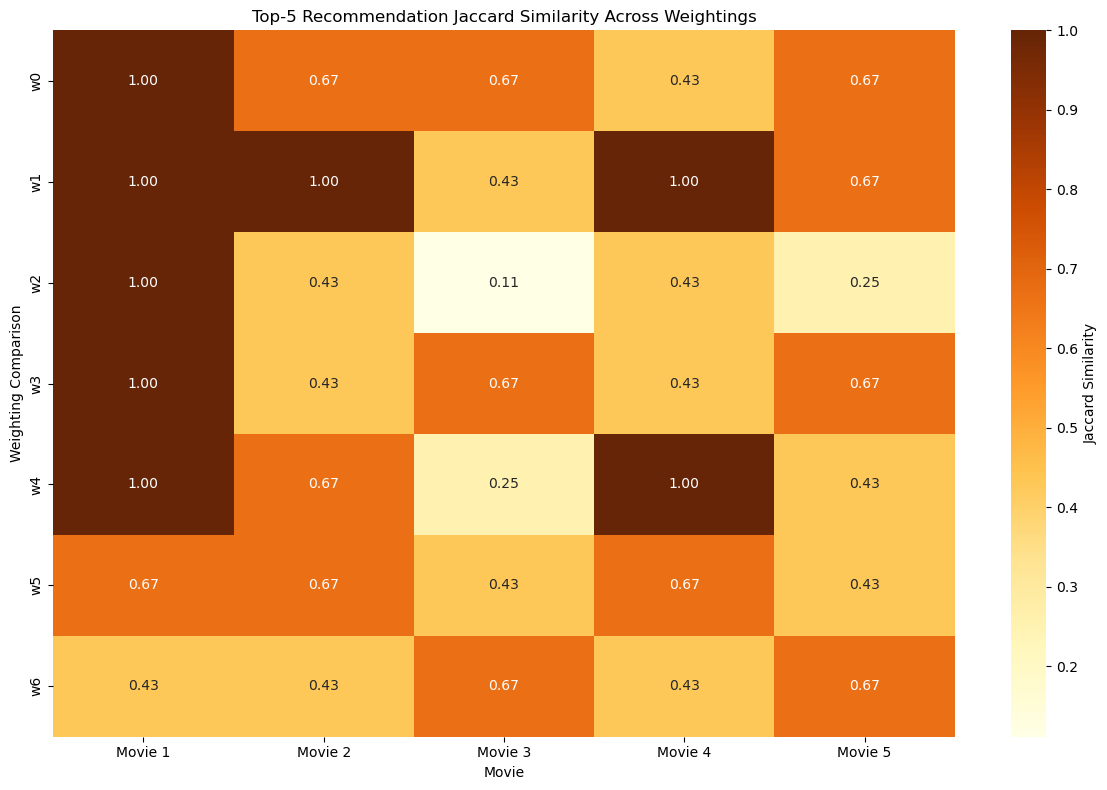

In [105]:
# Convert count-based overlap to Jaccard similarity
jaccard_df = overlap_df.copy()

for col in jaccard_df.columns:
    jaccard_df[col] = jaccard_df[col].apply(lambda x: x / (10 - x) if x < 5 else 1.0)  # Avoid div by zero

plt.figure(figsize=(12, 8))
sns.heatmap(jaccard_df, annot=True, cmap='YlOrBr', fmt=".2f", cbar_kws={'label': 'Jaccard Similarity'})
plt.title("Top-5 Recommendation Jaccard Similarity Across Weightings")
plt.xlabel("Movie")
plt.ylabel("Weighting Comparison")
plt.tight_layout()
plt.show()

From this, we can compare how each different weighting affects the set of recommendations change from an equal one.

Our rows refer to the following weightings:
- First weighting - fairly consistent across films
- Second weighting - very consistent across films
- Pure latent-space - very different, showing the impact of genre on recommendations
- Genre-dominant - fairly consistent
- PC-dominant - fairly consistent
- LF-dominant - consistent
- Genre-heavy - consistent

In terms of a recommender, it is not clear exactly what we would want. We do want the different types of recommenders to show a range of films, and not be focused on one idea, like *genre*. Certain films, like 'Movie 1' generally offers similar recommendations each time, whereas 'Movie 3' differs greatly based on the weighting. 
Despite this test, we believe that our second option seems to be optimal, ensuring that genre is not overpowered, and that the user data on tags and ratings is utilised.

>**Conclusion**
>
>From this, we can see that the following weighting seems like a suitable balance
$$\text{Score} = 0.4 \times \text{PC} + 0.4 \times \text{LF} + 0.2 \times \text{Genre}$$
and therefore this will be what we will proceed with this.
>
>We now have the item tower of a two-tower recommender system, which is based on a hybrid of film metadata, user-defined tags and user ratings. We can now recommend similar films to those like by the user. 

### Hybrid Similarity Search - User Tower
---

We will now consider the users, and see if we can use their data, and our item tower to find recommendations for them.

As our recommender is based on user ratings, and therefore an extensive input of data from users, there is enough data for each user to consider films that they already like and dislike. As user ratings are in the range $[0.5, 5]$, we could zero center this.
Therefore, we would weight their preferences with
$$\text{weighting} = \text{rating} - 2.75$$
Therefore
- **Liked films** positively influence
- **Netural films** have little impact
- **Disliked films** negatively influece 


In [122]:
prefered_weighting = [0.4,0.4,0.2]

In [222]:
def get_user_ratings_centered(user_id):
    """Return centered user ratings."""
    user_ratings = ratings[ratings['user_id'] == user_id][['item_id', 'rating']].copy()
    user_ratings['rating'] = user_ratings['rating'].fillna(0) - 2.75
    return user_ratings

In [223]:
def get_user_profile_embedding(item_ids, user_id=None, weight_by_rating=True):
    """Return user profile vector (PC, LF, Genre) from rated items, centered and weighted if possible."""

    # Subset the relevant movie features
    subset = all_movie_features[all_movie_features['item_id'].isin(item_ids)].copy()

    if weight_by_rating and user_id is not None:
        # Get centered user ratings
        rated = ratings[ratings['user_id'] == user_id][['item_id', 'rating']].copy()
        rated['rating'] = rated['rating'] - 2.75  # Centering

        # Merge ratings with movie features
        merged = subset.merge(rated, on='item_id', how='left')
        merged = merged.dropna(subset=['rating'])

        # Clip weights to avoid zeros or negatives
        merged['rating'] = merged['rating'].clip(lower=0.1)

        if not merged.empty and merged['rating'].sum() > 0:
            # Weighted averages with centered ratings
            weights = merged['rating']
            pc = np.nan_to_num(np.average(merged[pc_cols], weights=weights, axis=0))
            lf = np.nan_to_num(np.average(merged[lf_cols], weights=weights, axis=0))
            genre = np.nan_to_num(np.average(merged[genre_cols], weights=weights, axis=0))
            return pc, lf, genre

    # Fallback: if no ratings or all weights zero
    if subset.empty:
        subset = all_movie_features.copy()

    pc = np.nan_to_num(subset[pc_cols].mean().values)
    lf = np.nan_to_num(subset[lf_cols].mean().values)
    genre = np.nan_to_num(subset[genre_cols].mean().values)
    return pc, lf, genre

In [224]:
def hybrid_similarity_user_to_movie(user_pc, user_lf, user_genre, movie_row, weighting=(0.4, 0.4, 0.2)):
    """Compute hybrid similarity between user profile and a movie."""
    if (
        movie_row[pc_cols].isnull().any()
        or movie_row[lf_cols].isnull().any()
        or movie_row[genre_cols].isnull().any()
    ):
        return -1

    cos_pc = cosine_similarity([user_pc], [movie_row[pc_cols]])[0, 0]
    cos_lf = cosine_similarity([user_lf], [movie_row[lf_cols]])[0, 0]
    jac_genre = 1 - jaccard(user_genre, movie_row[genre_cols])

    return weighting[0]*cos_pc + weighting[1]*cos_lf + weighting[2]*jac_genre

In [225]:
def recommend_for_user_profile(user_id, top_n=10, weighting=(0.4, 0.4, 0.2)):
    """Recommend movies to a user based on hybrid profile similarity."""
    seen_ids = set(ratings[ratings['user_id'] == user_id]['item_id'])
    pc_vec, lf_vec, genre_vec = get_user_profile_embedding(seen_ids, user_id=user_id)

    scores = []
    for _, row in all_movie_features.iterrows():
        if row['item_id'] in seen_ids:
            continue
        score = hybrid_similarity_user_to_movie(pc_vec, lf_vec, genre_vec, row, weighting)
        scores.append((row['item_id'], score))

    return sorted(scores, key=lambda x: x[1], reverse=True)[:top_n]

In [226]:
def show_recommendations(user_id, top_n=5, weighting=(0.4, 0.4, 0.2)):
    """Print top-N movie recommendations for a user."""
    recs = recommend_for_user_profile(user_id, top_n=top_n, weighting=weighting)
    print(f"🎯 Recommendations for User {user_id}:")
    for item_id, score in recs:
        row = all_movie_features.loc[all_movie_features['item_id'] == item_id].iloc[0]
        title = all_movie_features.loc[all_movie_features['item_id'] == item_id, 'title'].values[0]
        print(f"- {title} | Genres: {row['genres']} (Score: {score:.3f})\n  Theme: {row['theme']}")

In [227]:
def print_user_recommendations(user_ids, ratings_df, metadata_df, top_n=5):
    """Print top-rated, bottom-rated, and recommended films for each user."""
    for user_id in user_ids:
        print(f"👤 User {user_id}")
        
        user_ratings = ratings_df[ratings_df['user_id'] == user_id]
        enriched = user_ratings.merge(
            metadata_df[['item_id', 'title', 'genres', 'theme']],
            on='item_id',
            how='left'
        )

        def print_ranked(ranked, label):
            print(label)
            for _, row in ranked.iterrows():
                print(f"- {row['title']} | Genres: {row['genres']} (Rating: {row['rating']})\n  Theme: {row['theme']}")
            print()

        print_ranked(enriched.sort_values('rating', ascending=False).head(top_n), "❤️ Top Rated Films:")
        print_ranked(enriched.sort_values('rating', ascending=True).head(top_n), "☢️ Bottom Rated Films:")

        print("🔮 Recommendations:")
        show_recommendations(user_id=user_id, top_n=top_n)
        print("-----------------------------------------------------------------------\n")

In [142]:
user_sample = [667138,226316,273387,485954,648979]
%time print_user_recommendations(user_sample, ratings, all_movie_features, top_n=5)

👤 User 667138
❤️ Top Rated Films:
- Toy Story (1995) | Genres: Adventure|Animation|Children|Comedy|Fantasy (Rating: 5.0)
  Theme: High-octane action and suspense, Family-friendly classics and animations
- American President, The (1995) | Genres: Comedy|Drama|Romance (Rating: 5.0)
  Theme: Post-apocalyptic dark romantic crime
- Sense and Sensibility (1995) | Genres: Drama|Romance (Rating: 5.0)
  Theme: Adaptations and British crime stories
- Apollo 13 (1995) | Genres: Adventure|Drama|IMAX (Rating: 5.0)
  Theme: High-octane action and suspense
- Persuasion (1995) | Genres: Drama|Romance (Rating: 5.0)
  Theme: British historical and political dramas

☢️ Bottom Rated Films:
- Hot Shots! Part Deux (1993) | Genres: Action|Comedy|War (Rating: 2.0)
  Theme: Comedy and humour-focused films
- Naked Gun 33 1/3: The Final Insult (1994) | Genres: Action|Comedy (Rating: 2.0)
  Theme: Comedy and humour-focused films
- Interview with the Vampire: The Vampire Chronicles (1994) | Genres: Drama|Horror (R

This hybrid approach produced noticeably different recommendations compared to the standard SVD model based solely on user ratings. While there is some overlap in results for certain users, the overall output is more diverse in genre. This suggests that the influence of Principal Components (PCs) and the relatively smaller weight assigned to genre may have led to a broader set of suggestions, avoiding overfitting to a single content type.

The thematic influence in particular is clearly visible. Many of the recommended films reflect a synthesis of emotional tone, narrative style, and genre, aligning with both user history and thematic embeddings. This highlights the added value of using tag-based themes and latent features to deepen the contextual understanding of what a user might enjoy — especially for users with eclectic preferences.

One of the notable strengths of this method is its capacity to surface a more varied set of films, potentially providing users with options that fit different moods or situational preferences. This contrasts with traditional collaborative filtering methods, which tend to reinforce narrow patterns based on user similarity.

That said, the primary drawback is the computational cost: each recommendation run takes approximately $20$ seconds per user. This is clearly not scalable for real-time deployment. However, for offline batch recommendation generation or when prioritising nuanced content diversity over speed, the trade-off may be justified, and as users would only be able to update their preferences through rating films, this would take the length of a film, and would not need to be done regularly. So, in practice, this run time would not be a major issue.

As a next step, we will examine how this diversity relates back to the themes and PCs used to drive recommendations. Similar to genre, these features also show a wide distribution across users — suggesting that the recommender may be implicitly offering users choices that span multiple content clusters, rather than committing to a singular user profile.

> **Conclusion**
> 
> We have successfully created a hybrid recommender algorithm, based on a two tower approach, using user ranked tags, user ratings and genre and people involved. We have been able to see the difference in the recommendations based on this, compared to a simple similarity search based on only user ratings.
>
> Our next step will be considering how well this works for users not included in the building of our item tower, and whether this will work with users with little data. We will need to consider the following:
> - Users with little or no data (User cold-start problem)
> - Films with little or no data (Item cold-start problem)
> - Further use of the *Themes* in supporting our recommenders (Deeper filtered recommendations to enhance user experience)

## Testing our Recommender System
---

We created a test set of users earlier, these are users whose data was not used in the creation of our recommender model. We will now see if we can recommend suitable films based on their data.

Training set users: 96859, ratings: 18901252
Test set users: 41512, ratings: 8042751

We do have plenty of test users, having taken $30\%$ for this purpose. This may have been unnessesary, as, due to time complexity, it will not be possible to test for this number of users. We should have, instead, used more users to construct or recommender to help improve its accuracy. However, we will hopefully find that it is sufficiently accurate inspite of this.

### Test Users
---

We will go back to our test user data, as these have not been used to make the model, this will demonstrate whether it can accurately recommend based on new data.

In [145]:
# sample test users
random.seed(42)
sample_users = random.sample(test_ratings['user_id'].unique().tolist(), 5)

print_user_recommendations(sample_users, ratings, all_movie_features, top_n=5)

👤 User 708402
❤️ Top Rated Films:
- Star Wars: Episode IV - A New Hope (1977) | Genres: Action|Adventure|Sci-Fi (Rating: 5.0)
  Theme: High-octane action and suspense, Family-friendly classics and animations
- Independence Day (a.k.a. ID4) (1996) | Genres: Action|Adventure|Sci-Fi|Thriller (Rating: 5.0)
  Theme: High-octane action and suspense
- Star Wars: Episode VI - Return of the Jedi (1983) | Genres: Action|Adventure|Sci-Fi (Rating: 5.0)
  Theme: High-octane action and suspense, Family-friendly classics and animations
- Courage Under Fire (1996) | Genres: Action|Crime|Drama|War (Rating: 4.0)
  Theme: Campy, cheesy action and war themes
- Twelve Monkeys (a.k.a. 12 Monkeys) (1995) | Genres: Mystery|Sci-Fi|Thriller (Rating: 4.0)
  Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense, Science fiction and speculative futures

☢️ Bottom Rated Films:
- Father of the Bride Part II (1995) | Genres: Comedy (Rating: 3.0)
  Theme: Fantasy and surreal mytholog

> **Conclusion**
>
> Overall, the hybrid recommender successfully introduces a diverse range of genres by leveraging shared thematic elements rather than confining users to a single genre. This flexibility highlights the strength of combining latent features, genres, and themes. The model also shows a strong ability to avoid recommending themes that users tend to dislike.
>
> However, some limitations are evident. For instance, User 226316 gave high ratings to critically acclaimed films but received no such recommendations. This suggests that the negative weighting or centering approach may be too aggressive in some cases. While the model centres ratings around the midpoint (e.g. 2.75), users have different rating behaviours—some consistently rate generously, others more harshly—so user-level standardisation may offer a better calibration.
>
> Additionally, some themes are over-represented in recommendations. "High-octane action and suspense" and "critically acclaimed, artistic, emotional dramas" appear frequently. These themes correspond to principal components that explain a large portion of the variance, and in the case of critically acclaimed films, may also correlate with higher average ratings. This suggests that the model may be overweighting dominant latent factors, leading to a lack of novelty in some recommendations.

### Cold Start Test - User
---

We would want to ensure that new users are able to be recommended films based on the highest user rated films. 

We will initially consider users with fewer than 2 ratings, in the hopes that some level of engagement will allow the recommender to still be somewhat effective, and not only produce generic recommendations.

In [146]:
# Count ratings per user
user_rating_counts = ratings['user_id'].value_counts()

# Set threshold
max_ratings = 2

# Filter users
non_active_users = user_rating_counts[user_rating_counts <= max_ratings].index

# Keep only those users
filtered_ratings = ratings[ratings['user_id'].isin(non_active_users)]

filtered_ratings.shape

(10338, 3)

Next, we will consider what the recommender will do with a user with no data. It should be recommended based on the highest rated films, but would be quite generic having no other information to go on.

In [156]:
# sample test users
random.seed(42)

# Sample 4 users who give high ratings
high_rated_users = filtered_ratings[filtered_ratings['rating'] >= 4.5]['user_id'].unique().tolist()
sample_high = random.sample(high_rated_users, 4)

# Sample 4 users who give low ratings
low_rated_users = filtered_ratings[filtered_ratings['rating'] <= 2.5]['user_id'].unique().tolist()
sample_low = random.sample(low_rated_users, 4)

# Combine sample
sample_users = sample_high + sample_low

# Print recommendations
print_user_recommendations(sample_users, ratings, all_movie_features, top_n=5)

👤 User 130275
❤️ Top Rated Films:
- Shawshank Redemption, The (1994) | Genres: Crime|Drama (Rating: 4.5)
  Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense

☢️ Bottom Rated Films:
- Shawshank Redemption, The (1994) | Genres: Crime|Drama (Rating: 4.5)
  Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense

🔮 Recommendations:
🎯 Recommendations for User 130275:
- Green Mile, The (1999) | Genres: Crime|Drama (Score: 0.695)
  Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense
- American History X (1998) | Genres: Crime|Drama (Score: 0.609)
  Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense
- Papillon (1973) | Genres: Crime|Drama (Score: 0.577)
  Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense
- One Flew Over the Cuckoo's Nest (1975) | Genres: Drama (Score: 0.569)
  Theme: Critically acclaimed, artis

For users with very limited data, the hybrid recommender performs surprisingly well. The combination of themes and genres creates a flexible similarity space, allowing it to suggest films that not only match known preferences but also diversify the recommendations. Even with only one or two ratings, the system generates coherent suggestions, showing that the thematic and genre embeddings contribute meaningfully to cold-start scenarios.

To evaluate the model further, we tested a completely new cold-start user with no prior ratings at all. Since such a user provides no data to build a personal profile, we modified the recommender to fall back on average user ratings for profile construction. This approach enables the recommender to generate a baseline similarity vector from the general population, essentially treating the new user as "average" in preference.

In [163]:
def recommend_for_user_profile(user_id, top_n=10, weighting=prefered_weighting):
    """Recommend movies to a user based on hybrid profile similarity."""
    seen_ids = set(ratings[ratings['user_id'] == user_id]['item_id'])
    pc_vec, lf_vec, genre_vec = get_user_profile_embedding(seen_ids, user_id=user_id)

    scores = []
    for _, row in all_movie_features.iterrows():
        if row['item_id'] in seen_ids:
            continue
        score = hybrid_similarity_user_to_movie(pc_vec, lf_vec, genre_vec, row, weighting)
        scores.append((row['item_id'], score))

    return sorted(scores, key=lambda x: x[1], reverse=True)[:top_n]

In [165]:
new_user_id = 999999

empty_rating = pd.DataFrame([{
    'user_id': new_user_id,
    'item_id': np.nan,
    'rating': np.nan
}])

# Append to ratings
ratings = pd.concat([ratings, empty_rating], ignore_index=True)

print_user_recommendations([new_user_id], ratings, all_movie_features, top_n=5)

👤 User 999999
❤️ Top Rated Films:
- Army of Darkness (1993) | Genres: Action|Adventure|Comedy|Fantasy|Horror (Rating: 5.0)
  Theme: High-octane action and suspense, Comedy and humour-focused films, Family-friendly classics and animations
- Halloween (1978) | Genres: Horror (Rating: 5.0)
  Theme: High-octane action and suspense, Dark, violent, disturbing thrillers, Classic horror and suspense
- Death at a Funeral (2007) | Genres: Comedy (Rating: 5.0)
  Theme: Comedy and humour-focused films
- 21 (2008) | Genres: Crime|Drama|Romance|Thriller (Rating: 5.0)
  Theme: Teen movies with alternate realities
- Yellow Submarine (1968) | Genres: Adventure|Animation|Comedy|Fantasy|Musical (Rating: 5.0)
  Theme: Family-friendly classics and animations

☢️ Bottom Rated Films:
- Avatar (2009) | Genres: Action|Adventure|Sci-Fi|IMAX (Rating: 1.5)
  Theme: High-octane action and suspense, Emotional coming-of-age or psychological dramas
- 2 Fast 2 Furious (Fast and the Furious 2, The) (2003) | Genres: Act

These are generally consistent with popular or accessible genres, particularly family-friendly animations and comedies. These align with the most frequent and high-rated themes in the dataset (e.g., Family-friendly classics and animations, Comedy and humour-focused films), making them safe default suggestions for a new user.

Although reasonable, these recommendations also highlight a potential bias toward popular and widely liked themes, which may reduce novelty and personalisation. Still, they provide a strong starting point for new users, and the system can quickly adapt as the user begins rating films

> **Conclusion**
>
> On uses with no data, the recommender, as expected, recommends very popular films with many recommendations. Later, we will consider a better way of approaching cold-start users, by using systems often employed by streaming services by collecting some preferences from users. From this, we will be able to improve this cold-start issue and recommend suitable films.

### Utilising PCA derived *Themes* in our Recommender
---

One benefit of the PCA derives *Themes* is that these offer slightly more information then just *genre* alone. Much like how *Netflix* breaks down recommendations into different *themes* or *genres* so you have recommendations for any mood, we will use our tag derived *themes* to do something similar.

In [237]:
from collections import Counter

def theme_based_user_recommendations(user_id, top_n=100, per_theme_n=5, weighting=[0.4, 0.4, 0.2]):
    """Recommend movies to a user, grouped by the top 3 most common themes in the top-N recommendations."""

    # Get top-N recommendations for the user
    recs = recommend_for_user_profile(user_id, top_n=top_n, weighting=weighting)

    # Add theme information to each recommendation
    recs_with_theme = []
    for item_id, score in recs:
        theme_row = all_movie_features.loc[all_movie_features['item_id'] == item_id, 'theme']
        theme = theme_row.values[0] if not theme_row.empty else None
        recs_with_theme.append({'item_id': item_id, 'score': score, 'theme': theme})

    # Count the most common non-null themes
    themes = [rec['theme'] for rec in recs_with_theme if pd.notna(rec['theme'])]
    top_themes = [theme for theme, _ in Counter(themes).most_common(3) if theme]

    if not top_themes:
        print(f"\n⚠️ No valid themes found in top {top_n} recommendations for user {user_id}.")
        return

    # Gather top scored recommendations per theme
    theme_recommendations = {}
    for theme in top_themes:
        # Filter and sort items by theme
        theme_items = [rec for rec in recs_with_theme if rec['theme'] == theme]
        top_theme_items = sorted(theme_items, key=lambda x: x['score'], reverse=True)[:per_theme_n]
        theme_recommendations[theme] = top_theme_items

    # Display recommendations grouped by theme
    print(f"\n🎯 Thematic Recommendations for User {user_id}:\n")

    for theme, items in theme_recommendations.items():
        print(f"🔹 Theme: {theme}")
        for rec in items:
         
            title_row = all_movie_features[all_movie_features['item_id'] == rec['item_id']]
            title = title_row['title'].values[0] if not title_row.empty else f"Unknown ({rec['item_id']})"
            print(f"  - {title} (Score: {rec['score']:.3f})")
        print()

In [238]:
random.seed(42)
sample_users = random.sample(test_ratings['user_id'].unique().tolist(), 5)

for user_id in sample_users:
    %time theme_based_user_recommendations(user_id)


🎯 Thematic Recommendations for User 708402:

🔹 Theme: High-octane action and suspense
  - Nutty Professor, The (1996) (Score: 0.444)
  - Back to the Future (1985) (Score: 0.436)
  - Star Trek II: The Wrath of Khan (1982) (Score: 0.432)
  - Star Trek (2009) (Score: 0.431)
  - King Kong (2005) (Score: 0.387)

🔹 Theme: High-octane action and suspense, Family-friendly classics and animations
  - Star Wars: Episode I - The Phantom Menace (1999) (Score: 0.506)
  - Star Wars: Episode III - Revenge of the Sith (2005) (Score: 0.487)
  - Star Wars: Episode II - Attack of the Clones (2002) (Score: 0.480)
  - Jurassic Park (1993) (Score: 0.471)
  - Indiana Jones and the Last Crusade (1989) (Score: 0.411)

🔹 Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense
  - Braveheart (1995) (Score: 0.358)
  - Ben-Hur (1959) (Score: 0.353)
  - Ben-Hur: A Tale of the Christ (1925) (Score: 0.342)
  - Gladiator (2000) (Score: 0.342)
  - Planet of the Apes (1968) (Score: 0.33

> **Conclusion**
>
> As demonstrated through our testing, the recommender performs well even for users with limited data. In cold-start scenarios, we found that the system can still provide relevant recommendations by leveraging metadata such as genre and theme. To avoid defaulting to generic, popular films, we can adjust the weightings to emphasise any available user data and prioritise content-based similarity, particularly genre and tag information, over collaborative filtering alone.
>
> We have tested the recommender across a variety of user types: those excluded from training data, users with only a few ratings, and completely cold-start users. Additionally, our theme-based recommendation strategy proved effective in clustering similar films and presenting meaningful variation across recommendations.
>
> We have successfully created a recommender which promotes key user themes and a range of films that align with that. Much like how Netflix has separated their user interface to aid in user navigation towards themes and genres that they feel like watching at any one time. It was key here to adjust our weighting to ensure that not just generic, popular films were recommended, but instead based on film meta data to provide a more tailored recommendation
>
> Overall, our recommender has worked successfully for a wide range of users, consistently offering diverse films that span multiple themes and genres. This enables the system to recommend content that reflects a user's preferences, while also accounting for the fact that users are not always in the mood for their usual genres or familiar styles, which is a key factor in enhancing user satisfaction and discovery.

## New User Data Collection
---

As common system, by many media platforms, if for new users to state their preferences when signing up. This allows the service to give slightly more tailored recommendations, even with no user data. We have trialled our method with users who had many ($30+$) recommendation, although many of them had over $100$, and trialled how it dealt with cold-start users with only $1$ or $2$ ratings. Although both of these managed to provide us with suitable and varied recommendations, more information will provide a more useful recommendation. Especially when a user with no data, will be given the same set of recommended movies, which are the highest rated across our user base.

Therefore, we will now trial a quick and simple function to allow a new user to provide some preferences. This is a basic system which will give a random sample of, by default $5$, films selected from the most commonly reviewed films (top $200$ to ensure enough variance of genre and theme), as these are likely to be the ones that most people have heard of or seen. It will then add our new user preferences to our user dataframe and recommend based on this, then perform our hybrid similarity search on this data.

This has its limitations, as although we are picking the most rated films, the user may not be aware of these. Ideally, these would not be a random sample, but instead the next choice of films would depend on the rating from the last. For example, if you like '*GoldenEye*', then the next film it may ask about may be another *James Bond*, to see if the user likes the series, and then another action/spy/thriller film to see whether it is a genre preference. It would also ensure it asks a range of genres to get a varied idea. Optimally, if the recommender had a hierarchical graph structure, it could as films based on this to enable us to find the cluster where the user is best placed. That would not work for our model, as our clustering did not yield any suitable results; however, we believe that with richer user data, this may be more likely.

In [228]:
def collect_user_input_ratings(ratings_df, metadata_df, num_movies=5, new_user_id=999999):
    """
    Simulates a cold-start user giving ratings to selected popular movies.
    
    Returns a DataFrame with new user's ratings.
    """
    print("Rate the following films to be given your Movie Recommendations.")
    
    # Identify popular movies
    popular_movies = (
        ratings_df['item_id']
        .value_counts()
        .head(200)  # top 200 most rated films
        .index
        .tolist()
    )
    
    # Sample a subset to show the user
    selected_ids = random.sample(popular_movies, num_movies)
    selected_movies = metadata_df[metadata_df['item_id'].isin(selected_ids)]

    # Collect user ratings
    user_ratings = []
    for _, row in selected_movies.iterrows():
        title = row['title']
        while True:
            try:
                rating = int(input(f"How would you rate '{title}' (1–5)? "))
                if rating < 1 or rating > 5:
                    raise ValueError("Rating must be between 1 and 5.")
                break
            except ValueError as e:
                print(f"Invalid input. {e}")
        
        user_ratings.append({
            'user_id': new_user_id,
            'item_id': row['item_id'],
            'rating': rating
        })

    new_user_df = pd.DataFrame(user_ratings)
    print("\nYour preferences have been recorded.\n")
    return new_user_df

In [231]:
new_user_ratings = collect_user_input_ratings(ratings, all_movie_features, num_movies=10, new_user_id=999999)

# Append to ratings
ratings = pd.concat([ratings, new_user_ratings], ignore_index=True)

# View new ratings
print(new_user_ratings)

# Generate recommendations
show_recommendations(999999, top_n=5)

Rate the following films to be given your Movie Recommendations.


How would you rate 'Fargo (1996)' (1–5)?  3
How would you rate 'Princess Bride, The (1987)' (1–5)?  2
How would you rate 'Indiana Jones and the Last Crusade (1989)' (1–5)?  5
How would you rate 'Back to the Future Part II (1989)' (1–5)?  3
How would you rate 'Airplane! (1980)' (1–5)?  2
How would you rate 'X-Men (2000)' (1–5)?  5
How would you rate 'O Brother, Where Art Thou? (2000)' (1–5)?  5
How would you rate 'Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)' (1–5)?  4
How would you rate 'Dark Knight, The (2008)' (1–5)?  5
How would you rate 'Avatar (2009)' (1–5)?  5



Your preferences have been recorded.

   user_id  item_id  rating
0   999999      608       3
1   999999     1197       2
2   999999     1291       5
3   999999     2011       3
4   999999     2791       2
5   999999     3793       5
6   999999     4027       5
7   999999     4896       4
8   999999    58559       5
9   999999    72998       5
🎯 Recommendations for User 999999:
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) | Genres: Action|Adventure (Score: 0.557)
  Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense, Family-friendly classics and animations
- Matrix, The (1999) | Genres: Action|Sci-Fi|Thriller (Score: 0.491)
  Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense, Teen movies with alternate realities
- Sixth Sense, The (1999) | Genres: Drama|Horror|Mystery (Score: 0.460)
  Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense
- 

This seems to recommend films well based on this user's input. They offer a small range of genres based on user input, but as the user has a focus towards action/Sci-Fi, this has been noted. 

Let us now trial for someone with a very mixed preference, although this will be challenging to guarantee due to the random selection of offered films.

In [232]:
new_user_ratings = collect_user_input_ratings(ratings, all_movie_features, num_movies=10, new_user_id=999999)

# Append to ratings
ratings = pd.concat([ratings, new_user_ratings], ignore_index=True)

# View new ratings
print(new_user_ratings)

# Generate recommendations
show_recommendations(999999, top_n=5)

Rate the following films to be given your Movie Recommendations.


How would you rate 'Shawshank Redemption, The (1994)' (1–5)?  2
How would you rate 'Aliens (1986)' (1–5)?  4
How would you rate 'When Harry Met Sally... (1989)' (1–5)?  5
How would you rate 'Star Trek: First Contact (1996)' (1–5)?  1
How would you rate 'L.A. Confidential (1997)' (1–5)?  3
How would you rate 'Titanic (1997)' (1–5)?  4
How would you rate 'Life Is Beautiful (La Vita è bella) (1997)' (1–5)?  3
How would you rate 'Airplane! (1980)' (1–5)?  1
How would you rate 'Cast Away (2000)' (1–5)?  3
How would you rate 'WALL·E (2008)' (1–5)?  5



Your preferences have been recorded.

   user_id  item_id  rating
0   999999      318       2
1   999999     1200       4
2   999999     1307       5
3   999999     1356       1
4   999999     1617       3
5   999999     1721       4
6   999999     2324       3
7   999999     2791       1
8   999999     4022       3
9   999999    60069       5
🎯 Recommendations for User 999999:
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) | Genres: Action|Adventure (Score: 0.555)
  Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense, Family-friendly classics and animations
- Matrix, The (1999) | Genres: Action|Sci-Fi|Thriller (Score: 0.489)
  Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense, Teen movies with alternate realities
- Sixth Sense, The (1999) | Genres: Drama|Horror|Mystery (Score: 0.461)
  Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense
- 

This still seems to push the more highly rated, critically acclaimed films, as you may expect for a user with little data.

We will consider a different weighting, to reduce the influence of the LF, as these are from user reviews, and instead use PC and Genre as a larger factor.
$$\text{Score} = 0.3 \times \text{PC} + 0.1 \times \text{LF} + 0.6 \times \text{Genre}$$

In [235]:
new_user_ratings = collect_user_input_ratings(ratings, all_movie_features, num_movies=10, new_user_id=999999)

# Append to ratings
ratings = pd.concat([ratings, new_user_ratings], ignore_index=True)

# View new ratings
print(new_user_ratings)

# Generate recommendations
show_recommendations(999999, top_n=5, weighting=(0.3,0.1,0.7))

Rate the following films to be given your Movie Recommendations.


How would you rate 'Outbreak (1995)' (1–5)?  1
How would you rate 'Dances with Wolves (1990)' (1–5)?  4
How would you rate 'Godfather, The (1972)' (1–5)?  2
How would you rate 'Men in Black (a.k.a. MIB) (1997)' (1–5)?  5
How would you rate 'Contact (1997)' (1–5)?  3
How would you rate 'Shakespeare in Love (1998)' (1–5)?  5
How would you rate 'Austin Powers: The Spy Who Shagged Me (1999)' (1–5)?  5
How would you rate 'Blair Witch Project, The (1999)' (1–5)?  4
How would you rate 'Snatch (2000)' (1–5)?  3
How would you rate 'Star Wars: Episode II - Attack of the Clones (2002)' (1–5)?  4



Your preferences have been recorded.

   user_id  item_id  rating
0   999999      292       1
1   999999      590       4
2   999999      858       2
3   999999     1580       5
4   999999     1584       3
5   999999     2396       5
6   999999     2683       5
7   999999     2710       4
8   999999     4011       3
9   999999     5378       4
🎯 Recommendations for User 999999:
- Inception (2010) | Genres: Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX (Score: 0.537)
  Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense, Emotional coming-of-age or psychological dramas
- Who Framed Roger Rabbit? (1988) | Genres: Adventure|Animation|Children|Comedy|Crime|Fantasy|Mystery (Score: 0.459)
  Theme: High-octane action and suspense, Family-friendly classics and animations
- Young Sherlock Holmes (1985) | Genres: Action|Adventure|Children|Fantasy|Mystery|Thriller (Score: 0.448)
  Theme: High-octane action and suspense
- Watchmen (2009) | Genres: Action|Dram

This change in weighting does seem to produce something a bit more varied. Therefore, maybe the weighting of different factors should vary depending on the situation, as it definitely has an impact for users with little data.

A final trial to have PC (tags) data and genre equally weighted
$$\text{Score} = 0.4 \times \text{PC} + 0.2 \times \text{LF} + 0.4 \times \text{Genre}$$

In [236]:
new_user_ratings = collect_user_input_ratings(ratings, all_movie_features, num_movies=10, new_user_id=999999)

# Append to ratings
ratings = pd.concat([ratings, new_user_ratings], ignore_index=True)

# View new ratings
print(new_user_ratings)

# Generate recommendations
show_recommendations(999999, top_n=5, weighting=(0.4,0.1,0.4))

Rate the following films to be given your Movie Recommendations.


How would you rate 'Die Hard: With a Vengeance (1995)' (1–5)?  4
How would you rate 'Casablanca (1942)' (1–5)?  5
How would you rate 'Die Hard (1988)' (1–5)?  5
How would you rate 'Reservoir Dogs (1992)' (1–5)?  3
How would you rate 'Psycho (1960)' (1–5)?  5
How would you rate 'Life Is Beautiful (La Vita è bella) (1997)' (1–5)?  4
How would you rate 'Almost Famous (2000)' (1–5)?  1
How would you rate 'Cast Away (2000)' (1–5)?  2
How would you rate 'Inglourious Basterds (2009)' (1–5)?  5
How would you rate 'Avatar (2009)' (1–5)?  3



Your preferences have been recorded.

   user_id  item_id  rating
0   999999      165       4
1   999999      912       5
2   999999     1036       5
3   999999     1089       3
4   999999     1219       5
5   999999     2324       4
6   999999     3897       1
7   999999     4022       2
8   999999    68157       5
9   999999    72998       3
🎯 Recommendations for User 999999:
- Inception (2010) | Genres: Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX (Score: 0.508)
  Theme: Critically acclaimed, artistic, emotional dramas, High-octane action and suspense, Emotional coming-of-age or psychological dramas
- Star Trek (2009) | Genres: Action|Adventure|Sci-Fi|IMAX (Score: 0.443)
  Theme: High-octane action and suspense
- Jurassic Park (1993) | Genres: Action|Adventure|Sci-Fi|Thriller (Score: 0.440)
  Theme: High-octane action and suspense, Family-friendly classics and animations
- Outlaw Josey Wales, The (1976) | Genres: Action|Adventure|Drama|Thriller|Western (Score: 0.434)
  Theme: Cr

This change in weighting does seem to produce something a varied set of films, but are still generic popular films.

> **Conclusion**
>
> We have successfully created a cold-start recommender application that can recommend films based on a sample of some popular films. The integration of tag data allows these recommendations to be more diverse than just genre-based recommendations or user ratings-based ones, which would often just recommend the most popular films. We can adjust the weighting of the recommender to tweak these suggestions, to dampen the effect of overly popular films and focus more on sthe imilarity of films through tags and genre.
>
> This could be further improved by how we sampled the random films asked of users to rate. A Hierarchical graph-based recommender could do this much better, and pick new films to ask each user to rate based on their previous preferences to aid in creating a more refined and accurate user profile. 


## Validation: Are our Recommendations Accurate?
---

Obvisouly, the key test of our recommendations would be wheter are users actually like the films we recommend. We will be unable to test this on mass, and did initially struggle to come up with ways of testing this. However, we will do the following

- sample users from `test_ratings`, ensuring that they have many ratings to ensure we have sufficient testing information

- Take a sample (30) of their ratings for films

- Find their top 5 recommended films

- Check if they have rated them, and what their rating was


Then, we can have a clear way of seeing whether we are recommending films that a user would actually like, and see the effectiveness of our recommender, and whether our *theme* based focus has made a stronger recommender then just collaborative filtering and genre alone.

In [241]:
def evaluate_recommendations_on_known_users(min_ratings=200, n_sample_users=5, profile_sample_size=30, top_n=5, seed=42):
    """Samples User Ratings, Recommends top n movies, Checks if already rated, Prints results"""
    random.seed(seed)

    # Filter users with at least `min_ratings` in test set
    eligible_users = test_ratings['user_id'].value_counts()
    eligible_users = eligible_users[eligible_users >= min_ratings].index.tolist()

    # Randomly select users
    selected_users = random.sample(eligible_users, n_sample_users)

    results = []

    for user_id in selected_users:
        # Get all their ratings and sample profile_sample_size for profile creation
        user_ratings = test_ratings[test_ratings['user_id'] == user_id]
        profile_sample = user_ratings.sample(profile_sample_size, random_state=seed)
        profile_items = set(profile_sample['item_id'])

        # Build user profile
        pc_vec, lf_vec, genre_vec = get_user_profile_embedding(profile_items, user_id=None, weight_by_rating=True)

        # Generate top-N recommendations (excluding profile items)
        scores = []
        for _, row in all_movie_features.iterrows():
            if row['item_id'] in profile_items:
                continue
            score = hybrid_similarity_user_to_movie(pc_vec, lf_vec, genre_vec, row)
            scores.append((row['item_id'], score))

        top_recs = sorted(scores, key=lambda x: x[1], reverse=True)[:top_n]

        # Print user summary
        print(f"\n👤 User {user_id} — Top {top_n} Recommendations:")
        for rec_id, score in top_recs:
            row = all_movie_features.loc[all_movie_features['item_id'] == rec_id]
            title = row['title'].values[0] if not row.empty else f"Unknown ({rec_id})"
            actual_rating = user_ratings.loc[user_ratings['item_id'] == rec_id, 'rating']
            if not actual_rating.empty:
                rating_display = f"Rated: {actual_rating.values[0]}"
                was_rated = True
            else:
                rating_display = "Not Rated"
                was_rated = False

            print(f"🎬 {title} (Score: {score:.3f}) → {rating_display}")

            # Append to results
            results.append({
                'user_id': user_id,
                'recommended_item_id': rec_id,
                'title': title,
                'score': score,
                'was_rated': was_rated,
                'actual_rating': actual_rating.values[0] if was_rated else None
            })

    return None

In [242]:
evaluate_recommendations_on_known_users(min_ratings=200, n_sample_users=20, profile_sample_size=30, top_n=5, seed=42)


👤 User 947142 — Top 5 Recommendations:
🎬 Die Hard (1988) (Score: 0.563) → Rated: 4.0
🎬 In the Line of Fire (1993) (Score: 0.532) → Rated: 3.0
🎬 Rock, The (1996) (Score: 0.526) → Rated: 4.0
🎬 Lethal Weapon (1987) (Score: 0.519) → Not Rated
🎬 Die Hard 2 (1990) (Score: 0.509) → Rated: 4.0

👤 User 365590 — Top 5 Recommendations:
🎬 Splash (1984) (Score: 0.583) → Not Rated
🎬 Big (1988) (Score: 0.570) → Not Rated
🎬 Mr. Mom (1983) (Score: 0.556) → Rated: 4.0
🎬 Adventures in Babysitting (1987) (Score: 0.553) → Not Rated
🎬 Ghost (1990) (Score: 0.545) → Not Rated

👤 User 412187 — Top 5 Recommendations:
🎬 Star Wars: Episode VI - Return of the Jedi (1983) (Score: 0.614) → Rated: 5.0
🎬 Star Wars: Episode II - Attack of the Clones (2002) (Score: 0.564) → Rated: 3.5
🎬 Star Wars: Episode I - The Phantom Menace (1999) (Score: 0.558) → Rated: 3.0
🎬 Star Wars: Episode III - Revenge of the Sith (2005) (Score: 0.526) → Rated: 4.0
🎬 Mummy Returns, The (2001) (Score: 0.474) → Not Rated

👤 User 142474 — Top 5

This is an interesting result. Some users, rated all the recommended films very highly, and some rated all, but only some highly (`User:947142`). However, there are some users (`User:365590`) who did not review (and from our data, let us assume also did not watch) many of the recommended films.

The mere existence of any rating does suggest that the user would have seen the film, and therefore, our recommendation is somewhat successful. The cases where users have rated them highly does suggest that our recommender has been successful.

We will catorgorise
- Good Recommendation: Highly rated Most Recommendations, Only Some rated, but all highly
- Average Recommendation: Most rated/viewed, Average or mix of ratings
- Bad Recommendation: Few rated, Many low ratings

**Good Recommendations**
- User 947142
- User 412187
- User 142474
- User 781499
- User 974511
- User 551427
- User 370914
- User 100906
- User 728992
- User 427948
- User 211880
- User 8278
- User 799891

**Average Recommendations**
- User 365590
- User 894197
- User 26837
- User 250634

**Bad**
- User 878779
- User 299007
- User 896443

Therefore, overall, these seem to be quite good recommendations for many of our users.

We will now do a simple count across a larger sample of users to see if this is effective for more users. We will trial this for 100 users, although the time complexity of this is high, and demonstrates that my approach is not scalable, but considering that in its application, each user would only need to generate this on their own device, we do not believe that this is a major concern.

In [244]:
def evaluate_recommendations_summary_aggregate(min_ratings=200, n_sample_users=5, profile_sample_size=30, top_n=5, seed=42):
    """
    Evaluate the overall performance of the recommender system across multiple known users by checking
    how many of the recommended items they have rated positively, negatively, or not rated at all.

    Parameters:
    -----------
    min_ratings : int, default=200
        Minimum number of ratings a user must have in the test set to be included in the evaluation sample.

    n_sample_users : int, default=5
        Number of users to sample for evaluation.

    profile_sample_size : int, default=30
        Number of movies to use from each sampled user's ratings to construct their profile.

    top_n : int, default=5
        Number of top recommendations to generate per user.

    seed : int, default=42
        Random seed for reproducibility of user sampling and profile movie selection.

    Returns:
    --------
    pd.DataFrame
        A single-row DataFrame summarising:
            - Total users evaluated
            - Total number of recommendations assessed
            - Count of 'Good' recommendations (user rating ≥ 3.5)
            - Count of 'Bad' recommendations (user rating < 3.5)
            - Count of 'Not Rated' recommendations
    """
    random.seed(seed)

    # Filter eligible users
    eligible_users = test_ratings['user_id'].value_counts()
    eligible_users = eligible_users[eligible_users >= min_ratings].index.tolist()
    selected_users = random.sample(eligible_users, n_sample_users)

    # Initialise counters
    count_good = 0
    count_bad = 0
    count_unrated = 0

    for user_id in selected_users:
        user_ratings = test_ratings[test_ratings['user_id'] == user_id]
        profile_sample = user_ratings.sample(profile_sample_size, random_state=seed)
        profile_items = set(profile_sample['item_id'])

        pc_vec, lf_vec, genre_vec = get_user_profile_embedding(profile_items, user_id=None, weight_by_rating=True)

        scores = []
        for _, row in all_movie_features.iterrows():
            if row['item_id'] in profile_items:
                continue
            score = hybrid_similarity_user_to_movie(pc_vec, lf_vec, genre_vec, row)
            scores.append((row['item_id'], score))

        top_recs = sorted(scores, key=lambda x: x[1], reverse=True)[:top_n]

        for rec_id, _ in top_recs:
            actual_rating = user_ratings.loc[user_ratings['item_id'] == rec_id, 'rating']
            if not actual_rating.empty:
                rating = actual_rating.values[0]
                if rating >= 3:
                    count_good += 1
                else:
                    count_bad += 1
            else:
                count_unrated += 1

    # Return as single-row DataFrame
    return pd.DataFrame([{
        'Users Sampled': n_sample_users,
        'Recommendations Evaluated': n_sample_users * top_n,
        'Good (≥3)': count_good,
        'Bad (<3)': count_bad,
        'Not Rated': count_unrated
    }])


In [248]:
%time evaluate_recommendations_summary_aggregate(min_ratings=200, n_sample_users=100, profile_sample_size=30, top_n=5, seed=142)

CPU times: total: 2h 15min 32s
Wall time: 2h 16min 41s


Users Sampled  Recommendations Evaluated  Good (≥3)  Bad (<3)  Not Rated
0            100                        500        338        37        125

In [249]:
print(f"% of Good Recommendations: {338/5}%")
print(f"% of Bad Recommendations: {37/5}%")
print(f"% of Not Rated: {125/5}%")

% of Good Recommendations: 67.6%
% of Bad Recommendations: 7.4%
% of Not Rated: 25.0%


> **Conclusion**
>
> Considering the suitability of our recommendations, they generally align well with each user's interests. Based on a random sample of their rated films, $67.6\%$ were good recommendations (so users rated this $3+$), $25\%$ of the recommendations had not been rated by the user, and only $7.4\%$ users rated as a bad film (below $3$). This demonstrates that our recommender has been effective in finding what users like, alongside its diverse range of recommendations through the use of user-based tags. This is especially promising given that these recommendations were based only on $30$ ratings for each user, and given the limited amount of data we had to show film preference and engagement. This seems comparitive to other recommenders who have meaningful user data like percentage of items watched, watchlists, scroll/clicks etc and without deep learning-based embeddings.
>
> A number of recommended films had not been rated by the users. Given the minimal data available, this could suggest either that some recommendations did not match user preferences or simply that users had not yet seen or rated those films. This does not necessarily indicate a flaw in the recommender, especially since our approach is intentionally designed to be more diverse than a standard genre-based or collaborative filtering system.
>
> A limitation with my testing was that I have only done this for a random sample of $100$ users. The time complexity of this is linear in terms of users checked, so as $100$ users took over $2 \text{ hours}$. We do have sufficient available test data to run for $1000$ users, this would take over $20 \text{ hours}$, and therefore not possible within this project. 


## Evaluation and Next Steps
---

A few things have been trialled and considered, but ultimately had to be left out of this exploration.

- **Actors and Directors**

We did attempt to use **MinHash** to account for preferences based on the approximate intersection of actors and directors. We initially implemented this and set a weighting of  
$$\text{Score} = 0.35 \times \text{PC} + 0.35 \times \text{LF} + 0.2 \times \text{Genre} + 0.1 \times \text{ActorsDirectors}$$  
We applied **Locality-Sensitive Hashing (LSH)** and **MinHash** to estimate this similarity, but failed to fully integrate this into the complete recommender.  
The key advantage of this is the obvious preference many people have for certain actors and directors—many users will often watch a film based on its cast or director. This is particularly prevalent in critically acclaimed films; for example, many people would watch a new *Quentin Tarantino* or *Bong Joon Ho* film simply because of the director. However, for some more generic action films, most users may not know or have a preference for the director. Therefore, this could have introduced unexpected bias into our recommender. Nevertheless, this is key metadata we have about films and is therefore a useful component when building our item tower.

- **Nearest Neighbour Algorithms**

Ideally, in constructing our user tower, we would have liked to recommend films to new users by identifying similar users and recommending the films they rated highly. However, no patterns or clusters could be found in this data using **HDBSCAN**.  
We believe that most users could probably be clustered based on their film preferences, but our data did not seem to reveal this. Perhaps richer or more complete data might allow us to observe and utilise these relationships, or perhaps a different handling of the tag data, such as using **FeatureHasher** or an alternative approach to dimensionality reduction, might yield better results.

- **Reviews**

We had access to user review data for films. One proposed idea was to use sentiment analysis to further interpret users' opinions and provide additional weight to their ratings. However, due to time constraints and the computational power required to process millions of reviews, we did not pursue this approach.

- **Plot**

To further aid in the deeper classification of films beyond genre, plot summaries could have been used alongside tags to help define the *theme* of each film. However, this data was not available in a format that could be easily integrated with this dataset, and was therefore not pursued.

- **Cold-Start Films**

We did consider examining the implications of cold-start films. Here, the focus would have been on genre as the key factor in making recommendations. This could also have served as a way of promoting lesser-known and obscure films to audiences.

However, in practice, streaming services often promote newly added content to users, partially to gain user data, but more importantly, because acquiring new content comes at a cost, and platforms want to maximise exposure. As such, cold-start issues for *new* films are less problematic. 

The greater concern is for older, niche films that lack engagement data. Due to our limited metadata, we were unable to meaningfully address this. If we had access to richer data, such as actors/directors, plot summaries, or sentiment analysis of reviews, we could have explored this problem more thoroughly and meaningfully.

- **User Profile Standardisation**

In considering user reviews to recommend films, we centred each user's ratings, so that highly rated films had a positive influence and lower-rated films had a negative impact on the user profile vector. 

However, different users exhibit different rating behaviours — some are generous, while others are more critical. Simply zero-centering the ratings may not adequately account for this. A better approach could involve **standardising each user's ratings** (e.g., subtracting their mean and dividing by their standard deviation), which would ensure that individual tendencies in rating behaviour are neutralised.

This, combined with other enhancements such as theme and genre blending, could result in a more powerful and personalised recommender.


---

**What we would like to consider in the future:**

- Exploration of explicit and implicit user data

That is, what films have been watched, what percentage of each film was watched, how many times a film has been watched, whether it was disliked, liked, or loved.  
This would mirror the kind of data that streaming platforms collect from users, and could be used to create a more in-depth recommender. It would allow us to enhance the user profile and examine how all these factors could build upon initial user preferences and similarities with other users.


## Conclusion
---

Overall, we have successfully created a two-tower recommender system for movies based on film metadata (genre), user-generated tags, and user ratings. It has been able to generate varied and diverse recommendations, which we have tested to align with users’ preferences and viewing history, generally. The primary focus was on using tags to generate thematic descriptions of films that go beyond basic genre classification, aiming to recommend a broader variety of films that highlight different characteristics. We believe this is essential in recommender systems, especially for films, as users often enjoy a wide range of genres depending on their mood. A system that relies too heavily on genre, or on actors and directors, can become overly narrow. Similarly, a collaborative filtering approach often reinforces popularity bias. A hybrid model, incorporating these elements alongside more subtle thematic features, has enabled more diverse and personalised recommendations. We have trialled a range of different weightings to see the impact of each component in recommendations, and they did vary quite significantly. Our approach also supports theme-based suggestions, helping users discover films that match how they feel, much like how platforms such as *Netflix* or *Spotify* provide mood-based recommendations.

The foundation of this thematic classification came from our **Principal Component Analysis (PCA)** on the tag data. Each **PC** was defined as a linear combination of user-generated tags, which, due to their interconnectedness, allowed us to form coherent themes that often cut across traditional genre boundaries. Many of these themes proved to be sensible and insightful. However, some themes were overly specific or ambiguous, such as "Teen-centred dramas, hip-hop culture, political or civil conflict-related themes", which may group together a wide range of otherwise unrelated films. Further refinement, such as exploring different numbers of components, could improve this. Too few components would merge distinct themes, while too many could dilute their interpretability and add complexity due to higher dimensionality.

One major challenge was the inability to find meaningful clusters in either the tag data or user ratings. Had this been possible, it could have enabled more advanced methods for similarity search. Ideally, we had hoped to identify more hierarchical or graph-based structures in the data to support faster and more intuitive similarity-based recommendations.

Another significant issue was the time complexity of our main recommendation algorithm. Generating the top five film recommendations per user takes around $20 \text{ seconds}$, which may appear unscalable. However, in practice, this is not necessarily problematic. The item-tower is static and can be updated periodically without affecting performance, and the user-tower only needs to be updated when new data is added. As users are unlikely to watch and rate new films frequently, recommendations do not need constant updating. Therefore, performance limitations are acceptable in this context. Nevertheless, optimising the system using vector-based indexing tools such as **FAISS** (Gautam, 2023) could improve scalability and allow integration of additional features, such as keyword search across plot, cast, or genre.

But the key limitation is the type of data used, as this is based on user rating, this requires significant input from users, whereas more of our engagement with media is with watching, clicks/scrolls etc, this method woud put a lot of onus on users to provide this level of detailed data, which is not practical for most users.

This exploration has demonstrated that a hybrid recommender system, supported by dimensionality reduction techniques and user-generated metadata, can produce rich and varied suggestions. By incorporating genre, user preferences, and thematic similarity, we have built a flexible and interpretable system. Future work could focus on improving the representation of themes, incorporating additional content data (such as reviews or plot summaries), and optimising performance. With these developments, such systems could better reflect the complex nature of film preference and serve as the foundation for a more responsive and nuanced recommender experience.


## Bibliography
---


Elston, S., 2025. CSCI S-108 Course Resources.

Gautam, A., 2023. Faiss, Lucene or NMSLIB — Which one is best for your VectorDB? [online] Medium. Available at: https://medium.com/@abhishekgautam_15881/faiss-lucene-or-nmslib-which-one-is-best-for-your-vectordb-e73bd2ddcc95 [Accessed 6 Aug. 2025].

GetEmoji.com, 2024. Get Emoji — All Emojis. [online] Available at: https://getemoji.com/ [Accessed 5 Aug. 2025].

GroupLens Research, 2024. MovieLens datasets. [online] Available at: https://grouplens.org/datasets/movielens/ [Accessed 5 Aug. 2025].

Hunter, J.D. and Matplotlib Developers, 2024. Matplotlib Documentation. [online] Available at: https://matplotlib.org/stable/contents.html [Accessed 5 Aug. 2025].

Hug, N., 2024. Surprise: A Python library for recommender systems. [online] Available at: https://surpriselib.com/ [Accessed 5 Aug. 2025].

Kotkov, D., Maslov, A. and Neovius, M., 2021. Revisiting the tag relevance prediction problem. In *Proceedings of the 44th International ACM SIGIR conference on Research and Development in Information Retrieval*. https://doi.org/10.1145/3404835.3463019

McInnes, L., Healy, J. and Melville, J., 2024. UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. [online] umap-learn. Available at: https://umap-learn.readthedocs.io/en/latest/ [Accessed 5 Aug. 2025].

NumPy Developers, 2024. NumPy Developer Documentation. [online] NumPy.org. Available at: https://numpy.org/devdocs/index.html [Accessed 5 Aug. 2025].

Pedregosa, F. *et al.*, 2024. scikit-learn: Machine Learning in Python. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/ [Accessed 5 Aug. 2025].

The pandas development team, 2024. pandas Documentation. [online] Available at: https://pandas.pydata.org/docs/ [Accessed 5 Aug. 2025].

Virtanen, P. *et al.*, 2024. scipy.sparse – Sparse matrices. [online] SciPy. Available at: https://docs.scipy.org/doc/scipy/reference/sparse.html [Accessed 5 Aug. 2025].

Vig, J., Sen, S. and Riedl, J., 2012. The tag genome: Encoding community knowledge to support novel interaction. *ACM Trans. Interact. Intell. Syst.*, 2(3), pp.13:1–13:44. https://doi.org/10.1145/2362394.2362395

Waskom, M. *et al.*, 2024. seaborn: statistical data visualization. [online] Available at: https://seaborn.pydata.org/ [Accessed 5 Aug. 2025].

Wikipedia, 2024. *List of highest-grossing films – Highest-grossing franchises and film series*. [online] Available at: https://en.wikipedia.org/wiki/List_of_highest-grossing_films#Highest-grossing_franchises_and_film_series [Accessed 17 Jul. 2025].
